# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Data loading and preprocessing

## Load the data

#### This time, the data will correspond to greyscale images. <br> Two different datasets can be used here:
- The MNIST dataset, small 8*8 images, corresponding to handwritten digits &rightarrow; 10 classes
- The Fashion MNIST dataset, medium 28*28 images, corresponding to clothes pictures &rightarrow; 10 classes

#### Starting with the simple MNIST is recommended

In [2]:
dataset = "MNIST"
# dataset = "FASHION_MNIST"

In [3]:
def load_data(dataset='MNIST'):
    if dataset == 'MNIST':
        digits = load_digits()
        X, Y = np.asarray(digits['data'], dtype='float32'), np.asarray(digits['target'], dtype='int32')
        return X, Y
    elif dataset == 'FASHION_MNIST':
        import tensorflow as tf
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (X, Y), (_, _) = fashion_mnist.load_data()
        X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
        X, Y = np.asarray(X, dtype='float32'), np.asarray(Y, dtype='int32')
        return X, Y
X, Y = load_data(dataset=dataset)

In [4]:
n_classes = len(np.unique(Y))

In [5]:
print('Number of samples: {:d}'.format(X.shape[0]))
print('Input dimension: {:d}'.format(X.shape[1]))  # images 8x8 or 28*28 actually
print('Number of classes: {:d}'.format(n_classes))

Number of samples: 1797
Input dimension: 64
Number of classes: 10


In [6]:
print("Range max-min of greyscale pixel values: ({0:.1f}, {1:.1f})".format(np.max(X), np.min(X)))
print("First image sample:\n{0}".format(X[0]))
print("First image label: {0}".format(Y[0]))
print("Input design matrix shape: {0}".format(X.shape))

Range max-min of greyscale pixel values: (16.0, 0.0)
First image sample:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
First image label: 0
Input design matrix shape: (1797, 64)


### What does the data look like?
Each image in the dataset consists of a 8 x 8 (or 28 x 28) matrix, of greyscale pixels. For the MNIST dataset, the values are between 0 and 16 where 0 represents white, 16 represents black and there are many shades of grey in-between. For the Fashion MNIST dataset, the values are between 0 and 255.<br>Each image is assigned a corresponding numerical label, so the image in ```X[i]``` has its corresponding label stored in ```Y[i]```.

The next cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset. 

## Visualize the data

In [7]:
def visualize_data_sample(X, Y, nrows=2, ncols=2):
    fig, ax = plt.subplots(nrows, ncols)
    for row in ax:
        for col in row:
            index = random.randint(0, X.shape[0])
            dim = np.sqrt(X.shape[1]).astype(int)
            col.imshow(X[index].reshape((dim, dim)), cmap=plt.cm.gray_r)
            col.set_title("image label: %d" % Y[index])
    plt.tight_layout()
    plt.show()

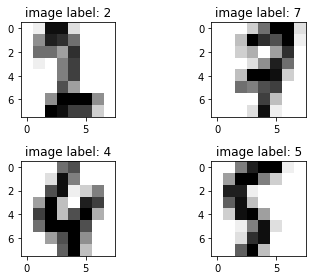

In [8]:
visualize_data_sample(X, Y)

# II - Multiclass classification MLP with Numpy

## II a) - Problem definition

<img src="../images/mlp_mnist.svg">

The task here will be to implement "from scratch" a Multilayer Perceptron for classification.

We will define the formal categorical cross entropy loss as follows:
$$
l(\mathbf{\Theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \log \mathbf{f}(\mathbf{x}_i ; \mathbf{\Theta})^\top y_i
$$
<center>with $y_i$ being the one-hot encoded true label for the sample $i$, and $\Theta = (\mathbf{W}^h; \mathbf{b}^h; \mathbf{W}^o; \mathbf{b}^o)$</center>
<center>In addition, $\mathbf{f}(\mathbf{x}) = softmax(\mathbf{z^o}(\mathbf{x})) = softmax(\mathbf{W}^o\mathbf{h}(\mathbf{x}) + \mathbf{b}^o)$</center>
<center>and $\mathbf{h}(\mathbf{x}) = g(\mathbf{z^h}(\mathbf{x})) = g(\mathbf{W}^h\mathbf{x} + \mathbf{b}^h)$, $g$ being the activation function and could be implemented with $sigmoid$ or $relu$</center>

## Objectives:
- Write the categorical cross entropy loss function
- Write the activation functions with their associated gradient
- Write the softmax function that is going to be used to output the predicted probabilities
- Implement the forward pass through the neural network
- Implement the backpropagation according to the used loss: progagate the gradients using the chain rule and return $(\mathbf{\nabla_{W^h}}l ; \mathbf{\nabla_{b^h}}l ; \mathbf{\nabla_{W^o}}l ; \mathbf{\nabla_{b^o}}l)$
- Implement dropout regularization in the forward pass: be careful to consider both training and prediction cases
- Implement the SGD optimization algorithm, and improve it with simple momentum

#### Simple graph function to let you have a global overview:

<img src="../images/function_graph.png" style="width: 750px;"/>

### Hints

1) You may find numpy outer products useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html <br>
We have: $outer(u, v) = u \cdot v^T$, with $u, v$ two vectors

Example:

In [9]:
u, v = np.random.normal(size=(5,)), np.random.normal(size=(10,))
assert np.array_equal(
    np.outer(u, v),
    np.dot(np.reshape(u, (u.size, 1)), np.reshape(v, (1, v.size)))
)
assert np.outer(u, v).shape == (5, 10)

1) You also may find numpy matmul function useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html <br>
It can be used to perform matrix products along one fixed dimension (i.e. the batch size)

Example:

In [10]:
A, B = np.random.randint(0, 100, size=(64, 5, 10)), np.random.randint(0, 100, size=(64, 10, 5))

In [11]:
assert np.array_equal(
    np.stack([np.dot(A_i, B_i) for A_i, B_i in zip(A, B)]),
    np.matmul(A, B)
)

## II b) - Implementation

In [12]:
class MultiLayerPerceptron():
    """MLP with one hidden layer having a hidden activation,
    and one output layer having a softmax activation"""
    def __init__(self, X, Y, hidden_size, activation='relu',
                 initialization='uniform', dropout=False, dropout_rate=0):
        # input, hidden, and output dimensions on the MLP based on X, Y
        self.input_size, self.output_size = X.shape[1], len(np.unique(Y))
        self.hidden_size = hidden_size
        # initialization strategies: avoid a full-0 initialization of the weight matrices
        if initialization == 'uniform':
            self.W_h = np.random.uniform(size=(self.hidden_size, self.input_size), high=0.01, low=-0.01)
            self.W_o = np.random.uniform(size=(self.output_size, self.hidden_size), high=0.01, low=-0.01)
        elif initialization == 'normal':
            self.W_h = np.random.normal(size=(self.hidden_size, self.input_size), loc=0, scale=0.01)
            self.W_o = np.random.normal(size=(self.output_size, self.hidden_size), loc=0, scale=0.01)
        # the bias could be initializated to 0 or a random low constant
        self.b_h = np.zeros(self.hidden_size)
        self.b_o = np.zeros(self.output_size)
        # our namedtuple structure of gradients
        self.Grads = namedtuple('Grads', ['W_h', 'b_h', 'W_o', 'b_o'])
        # and the velocities associated which are going to be useful for the momentum
        self.velocities = {'W_h': 0., 'b_h': 0., 'W_o': 0., 'b_o': 0.}
        # the hidden activation function used
        self.activation = activation
        # arrays to track back the losses and accuracies evolution
        self.training_losses_history = []
        self.validation_losses_history = []
        self.validation_acc_history = []
        # train val split and normalization of the features
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
        self.X_tr = self.scaler.fit_transform(self.X_tr)
        self.X_val = self.scaler.transform(self.X_val)
        # dropout parameters
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        # step used for the optimization algorithm and setted later
        self.step = None
    
    # One-hot encoding of the target
    # Transform the integer represensation to a sparse one
    @staticmethod
    def one_hot(n_classes, Y):
        return np.eye(n_classes)[Y]
    
    # Reverse one-hot encoding of the target
    # Recover the former integer representation
    # ex: from (0,0,1,0) to 2
    @staticmethod
    def reverse_one_hot(Y_one_hot):
        return np.asarray(np.where(Y_one_hot==1)[1], dtype='int32')
    
    """
    Activation functions and their gradient
    """
    # In implementations below X is a matrix of shape (n_samples, p)
    
    # A max_value value is indicated for the relu and grad_relu functions
    # Make sure to clip the output to it to prevent numerical overflow (exploding gradient)
    # Make it so the max value reachable is max_value
    @staticmethod
    def relu(X, max_value=20):
        assert max_value > 0
        return np.minimum(np.maximum(X, 0), max_value)
    
    # Make it so the gradient becomes 0 when X becomes greater than max_value
    @staticmethod
    def grad_relu(X, max_value=20):
        return ((X > 0) & (X < max_value)).astype('int32')
    
    @staticmethod
    def sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def grad_sigmoid(self, X):
        return self.sigmoid(X) * (1 - self.sigmoid(X))
    
    # Softmax function to output probabilities
    @staticmethod
    def softmax(X):
        exp = np.exp(X)
        return exp / np.sum(exp, axis=-1, keepdims=True)
    
    # Loss function
    # Consider using EPSILON to prevent numerical issues (log(0) is undefined)
    # Y_true and Y_pred are of shape (n_samples,n_classes)
    @staticmethod
    def categorical_cross_entropy(Y_true, Y_pred):
        loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
        result = -np.mean(loglikelihoods)
        return result
    
    @staticmethod
    def split_train_validation(X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
    
    # Sample random batch in (X, Y) with a given batch_size for SGD
    @staticmethod
    def get_random_batch(X, Y, batch_size):
        indexes = np.random.choice(X.shape[0], size=batch_size, replace=False)
        return X[indexes], Y[indexes]
        
    # Forward pass: compute f(x) as y, and return optionally the hidden states h(x) and z_h(x) for compute_grads
    def forward(self, X, return_activation=False, training=False):
        if self.activation == 'relu':
            g_activation = self.relu
        elif self.activation == 'sigmoid':
            g_activation = self.sigmoid
        else:
            raise NotImplementedError
    
        z_h = np.dot(self.W_h, X.T).T + self.b_h
        h = g_activation(z_h)
        if self.dropout:
            if training:
                dropout_mask = np.random.binomial(1, 1-self.dropout_rate, size=h.shape)
                h *= dropout_mask
            else:
                h *= (1-self.dropout_rate)
        z_o = np.dot(self.W_o, h.T).T + self.b_o
        y = self.softmax(z_o)
            
        if return_activation:
            return y, h, z_h
        else:
            return y
    
    # Backpropagation: return an instantiation of self.Grads that contains the average gradients for the given batch
    def compute_grads(self, X, Y_true, vectorized=False):
        if self.activation == 'relu':
            g_grad = self.grad_relu
        elif self.activation == 'sigmoid':
            g_grad = self.grad_sigmoid
        else:
            raise NotImplementedError
        
        if len(X.shape) == 1:
            X = X.reshape((1,) + X.shape)
        
        if not vectorized:
            n = X.shape[0]
            grad_W_h = np.zeros((self.hidden_size, self.input_size))
            grad_b_h = np.zeros((self.hidden_size, )) 
            grad_W_o = np.zeros((self.output_size, self.hidden_size))
            grad_b_o = np.zeros((self.output_size, ))
            for x, y_true in zip(X, Y_true):
                y_pred, h, z_h = self.forward(x, return_activation=True, training=True)
                
                grad_z_o = y_pred - self.one_hot(self.output_size, y_true)
                grad_W_o += np.outer(grad_z_o, h.T)
                grad_b_o += grad_z_o
                grad_h = np.dot(self.W_o.T, grad_z_o)
                
                grad_z_h = grad_h * g_grad(z_h)
                grad_W_h += np.outer(grad_z_h, x.T)
                grad_b_h += grad_z_h
                
            grads = self.Grads(grad_W_h/n, grad_b_h/n, grad_W_o/n, grad_b_o/n)
            
        else: 
            Y_pred, h, z_h = self.forward(X, return_activation=True, training=True)

            grad_z_o = Y_pred - self.one_hot(self.output_size, Y_true)
            grad_W_o = np.matmul(grad_z_o[:, :, np.newaxis], h[:, np.newaxis, :])
            grad_b_o = grad_z_o
            grad_h = np.dot(grad_z_o, self.W_o)

            grad_z_h = grad_h * g_grad(z_h)
            grad_W_h = np.matmul(grad_z_h[:, :, np.newaxis], X[:, np.newaxis, :])
            grad_b_h = grad_z_h
                    
            grads = self.Grads(
                np.mean(grad_W_h, axis=0),
                np.mean(grad_b_h, axis=0),
                np.mean(grad_W_o, axis=0),
                np.mean(grad_b_o, axis=0)
            )
            
        return grads
    
    # Perform the update of the parameters (W_h, b_h, W_o, b_o) based of their gradient
    def optimizer_step(self, optimizer='gd', momentum=False, momentum_alpha=0.9, 
                       batch_size=None, vectorized=True):
        if optimizer == 'gd':
            grads = self.compute_grads(self.X_tr, self.Y_tr, vectorized=vectorized)
        elif optimizer == 'sgd':
            batch_X_tr, batch_Y_tr = self.get_random_batch(self.X_tr, self.Y_tr, batch_size)
            grads = self.compute_grads(batch_X_tr, batch_Y_tr, vectorized=vectorized)
        else:
            raise NotImplementedError
        if not momentum:
            self.W_h -= self.step * grads.W_h
            self.b_h -= self.step * grads.b_h
            self.W_o -= self.step * grads.W_o
            self.b_o -= self.step * grads.b_o
        else:
            self.velocities['W_h'] = momentum_alpha * self.velocities['W_h'] - self.step * grads.W_h
            self.W_h += self.velocities['W_h']
            self.velocities['b_h'] = momentum_alpha * self.velocities['b_h'] - self.step * grads.b_h
            self.b_h += self.velocities['b_h']
            self.velocities['W_o'] = momentum_alpha * self.velocities['W_o'] - self.step * grads.W_o
            self.W_o += self.velocities['W_o']
            self.velocities['b_o'] = momentum_alpha * self.velocities['b_o'] - self.step * grads.b_o
            self.b_o += self.velocities['b_o']
    
    # Loss wrapper
    def loss(self, Y_true, Y_pred):
        return self.categorical_cross_entropy(self.one_hot(self.output_size, Y_true), Y_pred)
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
        
    # Main function that trains the MLP with a design matrix X and a target vector Y
    def train(self, optimizer='sgd', momentum=False, min_iterations=500, max_iterations=5000, initial_step=1e-1,
              batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
              vectorized=False, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        self.step = initial_step
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.optimizer_step(
                optimizer=optimizer, momentum=momentum, batch_size=batch_size, vectorized=vectorized
            )
            training_loss = self.loss(self.Y_tr, self.forward(self.X_tr))
            self.training_losses_history.append(training_loss)
            validation_loss = self.loss(self.Y_val, self.forward(self.X_val))
            self.validation_losses_history.append(validation_loss)
            validation_accuracy = self.accuracy_on_validation()
            self.validation_acc_history.append(validation_accuracy)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t" + \
                "validation loss: {2:.4f}\t validation accuracy: {3:.4f}"
                print(msg.format(iteration_number, 
                                 training_loss,
                                 validation_loss,
                                 validation_accuracy))
            if cpt_patience >= early_stopping_lookbehind:
                break
    
    # Return the predicted class once the MLP has been trained
    def predict(self, X, normalize=True):
        if normalize:
            X = self.scaler.transform(X)
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
        
    """
    Metrics and plots
    """
    def accuracy_on_train(self):
        return (self.predict(self.X_tr, normalize=False) == self.Y_tr).mean()

    def accuracy_on_validation(self):
        return (self.predict(self.X_val, normalize=False) == self.Y_val).mean()

    def plot_loss_history(self, add_to_title=None):
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)),
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("Cross entropy loss", fontsize=15)
        base_title = "Cross entropy loss evolution during training"
        if not self.dropout:
            base_title += ", no dropout penalization"
        else:
            base_title += ", {:.2f} dropout penalization"
            base_title = base_title.format(self.dropout_rate)
        title = base_title + ", " + add_to_title if add_to_title else base_title
        plt.title(title, fontsize=20)
        plt.show()
        
    def plot_validation_prediction(self, sample_id):
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        classes = np.unique(self.Y_tr)
        dim = np.sqrt(self.X_val.shape[1]).astype(int)
        ax0.imshow(self.scaler.inverse_transform([self.X_val[sample_id]]).reshape(dim, dim), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % self.Y_val[sample_id]);

        ax1.bar(classes, self.one_hot(len(classes), self.Y_val[sample_id]), label='true')
        ax1.bar(classes, self.forward(self.X_val[sample_id]), label='prediction', color="red")
        ax1.set_xticks(classes)
        prediction = self.predict(self.X_val[sample_id], normalize=False)
        ax1.set_title('Output probabilities (prediction: %d)' % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()

#### Standard MLP

In [13]:
mlp = MultiLayerPerceptron(X, Y, hidden_size=50, activation='relu')
mlp.train(vectorized=True, early_stopping=False)

iteration number: 1	 training loss: 2.3026	validation loss: 2.3026	 validation accuracy: 0.0933
iteration number: 2	 training loss: 2.3026	validation loss: 2.3026	 validation accuracy: 0.1111
iteration number: 3	 training loss: 2.3025	validation loss: 2.3025	 validation accuracy: 0.1622
iteration number: 4	 training loss: 2.3025	validation loss: 2.3025	 validation accuracy: 0.1667
iteration number: 5	 training loss: 2.3025	validation loss: 2.3024	 validation accuracy: 0.1689
iteration number: 6	 training loss: 2.3025	validation loss: 2.3024	 validation accuracy: 0.1111
iteration number: 7	 training loss: 2.3024	validation loss: 2.3023	 validation accuracy: 0.1111
iteration number: 8	 training loss: 2.3023	validation loss: 2.3024	 validation accuracy: 0.1133
iteration number: 9	 training loss: 2.3023	validation loss: 2.3022	 validation accuracy: 0.1111
iteration number: 10	 training loss: 2.3022	validation loss: 2.3023	 validation accuracy: 0.1689
iteration number: 11	 training loss: 2.

iteration number: 154	 training loss: 2.1865	validation loss: 2.1852	 validation accuracy: 0.5600
iteration number: 155	 training loss: 2.1820	validation loss: 2.1809	 validation accuracy: 0.4933
iteration number: 156	 training loss: 2.1782	validation loss: 2.1767	 validation accuracy: 0.5511
iteration number: 157	 training loss: 2.1736	validation loss: 2.1730	 validation accuracy: 0.5156
iteration number: 158	 training loss: 2.1697	validation loss: 2.1688	 validation accuracy: 0.5200
iteration number: 159	 training loss: 2.1655	validation loss: 2.1656	 validation accuracy: 0.4800
iteration number: 160	 training loss: 2.1613	validation loss: 2.1620	 validation accuracy: 0.4267
iteration number: 161	 training loss: 2.1569	validation loss: 2.1564	 validation accuracy: 0.4689
iteration number: 162	 training loss: 2.1519	validation loss: 2.1513	 validation accuracy: 0.4778
iteration number: 163	 training loss: 2.1466	validation loss: 2.1456	 validation accuracy: 0.4711
iteration number: 16

iteration number: 303	 training loss: 0.8281	validation loss: 0.7771	 validation accuracy: 0.8822
iteration number: 304	 training loss: 0.8203	validation loss: 0.7698	 validation accuracy: 0.8756
iteration number: 305	 training loss: 0.8151	validation loss: 0.7612	 validation accuracy: 0.8756
iteration number: 306	 training loss: 0.8125	validation loss: 0.7604	 validation accuracy: 0.8578
iteration number: 307	 training loss: 0.8039	validation loss: 0.7510	 validation accuracy: 0.8778
iteration number: 308	 training loss: 0.8014	validation loss: 0.7477	 validation accuracy: 0.8800
iteration number: 309	 training loss: 0.7947	validation loss: 0.7433	 validation accuracy: 0.8667
iteration number: 310	 training loss: 0.7873	validation loss: 0.7344	 validation accuracy: 0.8778
iteration number: 311	 training loss: 0.7841	validation loss: 0.7326	 validation accuracy: 0.8756
iteration number: 312	 training loss: 0.7796	validation loss: 0.7273	 validation accuracy: 0.8689
iteration number: 31

iteration number: 453	 training loss: 0.4001	validation loss: 0.3592	 validation accuracy: 0.9311
iteration number: 454	 training loss: 0.3958	validation loss: 0.3533	 validation accuracy: 0.9356
iteration number: 455	 training loss: 0.3966	validation loss: 0.3543	 validation accuracy: 0.9333
iteration number: 456	 training loss: 0.3962	validation loss: 0.3544	 validation accuracy: 0.9356
iteration number: 457	 training loss: 0.3938	validation loss: 0.3522	 validation accuracy: 0.9356
iteration number: 458	 training loss: 0.3932	validation loss: 0.3529	 validation accuracy: 0.9333
iteration number: 459	 training loss: 0.3925	validation loss: 0.3520	 validation accuracy: 0.9356
iteration number: 460	 training loss: 0.3920	validation loss: 0.3530	 validation accuracy: 0.9333
iteration number: 461	 training loss: 0.3943	validation loss: 0.3550	 validation accuracy: 0.9378
iteration number: 462	 training loss: 0.3874	validation loss: 0.3468	 validation accuracy: 0.9378
iteration number: 46

iteration number: 605	 training loss: 0.2641	validation loss: 0.2384	 validation accuracy: 0.9378
iteration number: 606	 training loss: 0.2637	validation loss: 0.2373	 validation accuracy: 0.9378
iteration number: 607	 training loss: 0.2641	validation loss: 0.2377	 validation accuracy: 0.9356
iteration number: 608	 training loss: 0.2598	validation loss: 0.2344	 validation accuracy: 0.9378
iteration number: 609	 training loss: 0.2612	validation loss: 0.2356	 validation accuracy: 0.9378
iteration number: 610	 training loss: 0.2644	validation loss: 0.2364	 validation accuracy: 0.9378
iteration number: 611	 training loss: 0.2616	validation loss: 0.2353	 validation accuracy: 0.9356
iteration number: 612	 training loss: 0.2607	validation loss: 0.2354	 validation accuracy: 0.9400
iteration number: 613	 training loss: 0.2591	validation loss: 0.2339	 validation accuracy: 0.9467
iteration number: 614	 training loss: 0.2581	validation loss: 0.2312	 validation accuracy: 0.9422
iteration number: 61

iteration number: 755	 training loss: 0.2046	validation loss: 0.1916	 validation accuracy: 0.9467
iteration number: 756	 training loss: 0.2011	validation loss: 0.1891	 validation accuracy: 0.9467
iteration number: 757	 training loss: 0.2006	validation loss: 0.1899	 validation accuracy: 0.9444
iteration number: 758	 training loss: 0.2049	validation loss: 0.1953	 validation accuracy: 0.9444
iteration number: 759	 training loss: 0.2048	validation loss: 0.1953	 validation accuracy: 0.9400
iteration number: 760	 training loss: 0.2180	validation loss: 0.2049	 validation accuracy: 0.9356
iteration number: 761	 training loss: 0.2033	validation loss: 0.1928	 validation accuracy: 0.9467
iteration number: 762	 training loss: 0.2009	validation loss: 0.1901	 validation accuracy: 0.9422
iteration number: 763	 training loss: 0.1992	validation loss: 0.1890	 validation accuracy: 0.9422
iteration number: 764	 training loss: 0.1998	validation loss: 0.1900	 validation accuracy: 0.9422
iteration number: 76

iteration number: 912	 training loss: 0.1710	validation loss: 0.1642	 validation accuracy: 0.9600
iteration number: 913	 training loss: 0.1666	validation loss: 0.1622	 validation accuracy: 0.9511
iteration number: 914	 training loss: 0.1669	validation loss: 0.1625	 validation accuracy: 0.9511
iteration number: 915	 training loss: 0.1657	validation loss: 0.1605	 validation accuracy: 0.9578
iteration number: 916	 training loss: 0.1644	validation loss: 0.1598	 validation accuracy: 0.9533
iteration number: 917	 training loss: 0.1674	validation loss: 0.1596	 validation accuracy: 0.9556
iteration number: 918	 training loss: 0.1667	validation loss: 0.1595	 validation accuracy: 0.9533
iteration number: 919	 training loss: 0.1680	validation loss: 0.1606	 validation accuracy: 0.9556
iteration number: 920	 training loss: 0.1658	validation loss: 0.1575	 validation accuracy: 0.9533
iteration number: 921	 training loss: 0.1653	validation loss: 0.1574	 validation accuracy: 0.9556
iteration number: 92

iteration number: 1068	 training loss: 0.1453	validation loss: 0.1419	 validation accuracy: 0.9578
iteration number: 1069	 training loss: 0.1421	validation loss: 0.1402	 validation accuracy: 0.9622
iteration number: 1070	 training loss: 0.1429	validation loss: 0.1398	 validation accuracy: 0.9622
iteration number: 1071	 training loss: 0.1399	validation loss: 0.1377	 validation accuracy: 0.9578
iteration number: 1072	 training loss: 0.1403	validation loss: 0.1383	 validation accuracy: 0.9578
iteration number: 1073	 training loss: 0.1390	validation loss: 0.1360	 validation accuracy: 0.9600
iteration number: 1074	 training loss: 0.1395	validation loss: 0.1353	 validation accuracy: 0.9600
iteration number: 1075	 training loss: 0.1399	validation loss: 0.1363	 validation accuracy: 0.9578
iteration number: 1076	 training loss: 0.1402	validation loss: 0.1391	 validation accuracy: 0.9600
iteration number: 1077	 training loss: 0.1415	validation loss: 0.1377	 validation accuracy: 0.9556
iteration 

iteration number: 1216	 training loss: 0.1238	validation loss: 0.1258	 validation accuracy: 0.9644
iteration number: 1217	 training loss: 0.1238	validation loss: 0.1253	 validation accuracy: 0.9622
iteration number: 1218	 training loss: 0.1239	validation loss: 0.1246	 validation accuracy: 0.9667
iteration number: 1219	 training loss: 0.1240	validation loss: 0.1259	 validation accuracy: 0.9622
iteration number: 1220	 training loss: 0.1235	validation loss: 0.1249	 validation accuracy: 0.9667
iteration number: 1221	 training loss: 0.1236	validation loss: 0.1239	 validation accuracy: 0.9667
iteration number: 1222	 training loss: 0.1230	validation loss: 0.1234	 validation accuracy: 0.9667
iteration number: 1223	 training loss: 0.1224	validation loss: 0.1243	 validation accuracy: 0.9689
iteration number: 1224	 training loss: 0.1235	validation loss: 0.1261	 validation accuracy: 0.9667
iteration number: 1225	 training loss: 0.1232	validation loss: 0.1265	 validation accuracy: 0.9667
iteration 

iteration number: 1371	 training loss: 0.1110	validation loss: 0.1111	 validation accuracy: 0.9756
iteration number: 1372	 training loss: 0.1106	validation loss: 0.1119	 validation accuracy: 0.9756
iteration number: 1373	 training loss: 0.1100	validation loss: 0.1114	 validation accuracy: 0.9733
iteration number: 1374	 training loss: 0.1117	validation loss: 0.1113	 validation accuracy: 0.9711
iteration number: 1375	 training loss: 0.1119	validation loss: 0.1127	 validation accuracy: 0.9667
iteration number: 1376	 training loss: 0.1114	validation loss: 0.1117	 validation accuracy: 0.9689
iteration number: 1377	 training loss: 0.1115	validation loss: 0.1109	 validation accuracy: 0.9733
iteration number: 1378	 training loss: 0.1120	validation loss: 0.1124	 validation accuracy: 0.9733
iteration number: 1379	 training loss: 0.1102	validation loss: 0.1114	 validation accuracy: 0.9756
iteration number: 1380	 training loss: 0.1112	validation loss: 0.1116	 validation accuracy: 0.9733
iteration 

iteration number: 1525	 training loss: 0.1008	validation loss: 0.1082	 validation accuracy: 0.9689
iteration number: 1526	 training loss: 0.1010	validation loss: 0.1060	 validation accuracy: 0.9711
iteration number: 1527	 training loss: 0.0998	validation loss: 0.1066	 validation accuracy: 0.9689
iteration number: 1528	 training loss: 0.0997	validation loss: 0.1060	 validation accuracy: 0.9689
iteration number: 1529	 training loss: 0.1010	validation loss: 0.1083	 validation accuracy: 0.9689
iteration number: 1530	 training loss: 0.1018	validation loss: 0.1095	 validation accuracy: 0.9667
iteration number: 1531	 training loss: 0.1008	validation loss: 0.1074	 validation accuracy: 0.9689
iteration number: 1532	 training loss: 0.1007	validation loss: 0.1066	 validation accuracy: 0.9711
iteration number: 1533	 training loss: 0.1009	validation loss: 0.1075	 validation accuracy: 0.9733
iteration number: 1534	 training loss: 0.1014	validation loss: 0.1078	 validation accuracy: 0.9733
iteration 

iteration number: 1679	 training loss: 0.0952	validation loss: 0.1026	 validation accuracy: 0.9711
iteration number: 1680	 training loss: 0.0948	validation loss: 0.1011	 validation accuracy: 0.9711
iteration number: 1681	 training loss: 0.0941	validation loss: 0.0988	 validation accuracy: 0.9778
iteration number: 1682	 training loss: 0.0937	validation loss: 0.0978	 validation accuracy: 0.9756
iteration number: 1683	 training loss: 0.0932	validation loss: 0.0968	 validation accuracy: 0.9778
iteration number: 1684	 training loss: 0.0925	validation loss: 0.0971	 validation accuracy: 0.9756
iteration number: 1685	 training loss: 0.0923	validation loss: 0.0968	 validation accuracy: 0.9733
iteration number: 1686	 training loss: 0.0926	validation loss: 0.0983	 validation accuracy: 0.9756
iteration number: 1687	 training loss: 0.0948	validation loss: 0.1014	 validation accuracy: 0.9711
iteration number: 1688	 training loss: 0.0933	validation loss: 0.0999	 validation accuracy: 0.9733
iteration 

iteration number: 1835	 training loss: 0.0879	validation loss: 0.0941	 validation accuracy: 0.9800
iteration number: 1836	 training loss: 0.0900	validation loss: 0.0974	 validation accuracy: 0.9756
iteration number: 1837	 training loss: 0.0860	validation loss: 0.0955	 validation accuracy: 0.9778
iteration number: 1838	 training loss: 0.0853	validation loss: 0.0947	 validation accuracy: 0.9778
iteration number: 1839	 training loss: 0.0854	validation loss: 0.0944	 validation accuracy: 0.9733
iteration number: 1840	 training loss: 0.0857	validation loss: 0.0930	 validation accuracy: 0.9733
iteration number: 1841	 training loss: 0.0862	validation loss: 0.0922	 validation accuracy: 0.9778
iteration number: 1842	 training loss: 0.0858	validation loss: 0.0919	 validation accuracy: 0.9800
iteration number: 1843	 training loss: 0.0848	validation loss: 0.0923	 validation accuracy: 0.9800
iteration number: 1844	 training loss: 0.0843	validation loss: 0.0918	 validation accuracy: 0.9778
iteration 

iteration number: 1985	 training loss: 0.0797	validation loss: 0.0895	 validation accuracy: 0.9756
iteration number: 1986	 training loss: 0.0803	validation loss: 0.0903	 validation accuracy: 0.9756
iteration number: 1987	 training loss: 0.0818	validation loss: 0.0922	 validation accuracy: 0.9756
iteration number: 1988	 training loss: 0.0802	validation loss: 0.0903	 validation accuracy: 0.9756
iteration number: 1989	 training loss: 0.0819	validation loss: 0.0913	 validation accuracy: 0.9756
iteration number: 1990	 training loss: 0.0820	validation loss: 0.0916	 validation accuracy: 0.9733
iteration number: 1991	 training loss: 0.0792	validation loss: 0.0909	 validation accuracy: 0.9756
iteration number: 1992	 training loss: 0.0796	validation loss: 0.0904	 validation accuracy: 0.9756
iteration number: 1993	 training loss: 0.0800	validation loss: 0.0905	 validation accuracy: 0.9778
iteration number: 1994	 training loss: 0.0801	validation loss: 0.0910	 validation accuracy: 0.9778
iteration 

iteration number: 2128	 training loss: 0.0753	validation loss: 0.0855	 validation accuracy: 0.9778
iteration number: 2129	 training loss: 0.0750	validation loss: 0.0858	 validation accuracy: 0.9778
iteration number: 2130	 training loss: 0.0744	validation loss: 0.0845	 validation accuracy: 0.9778
iteration number: 2131	 training loss: 0.0744	validation loss: 0.0848	 validation accuracy: 0.9800
iteration number: 2132	 training loss: 0.0742	validation loss: 0.0843	 validation accuracy: 0.9800
iteration number: 2133	 training loss: 0.0739	validation loss: 0.0843	 validation accuracy: 0.9778
iteration number: 2134	 training loss: 0.0742	validation loss: 0.0850	 validation accuracy: 0.9756
iteration number: 2135	 training loss: 0.0741	validation loss: 0.0842	 validation accuracy: 0.9778
iteration number: 2136	 training loss: 0.0739	validation loss: 0.0840	 validation accuracy: 0.9778
iteration number: 2137	 training loss: 0.0744	validation loss: 0.0840	 validation accuracy: 0.9778
iteration 

iteration number: 2282	 training loss: 0.0726	validation loss: 0.0836	 validation accuracy: 0.9778
iteration number: 2283	 training loss: 0.0709	validation loss: 0.0830	 validation accuracy: 0.9800
iteration number: 2284	 training loss: 0.0705	validation loss: 0.0824	 validation accuracy: 0.9756
iteration number: 2285	 training loss: 0.0699	validation loss: 0.0818	 validation accuracy: 0.9756
iteration number: 2286	 training loss: 0.0697	validation loss: 0.0813	 validation accuracy: 0.9756
iteration number: 2287	 training loss: 0.0700	validation loss: 0.0815	 validation accuracy: 0.9778
iteration number: 2288	 training loss: 0.0705	validation loss: 0.0817	 validation accuracy: 0.9800
iteration number: 2289	 training loss: 0.0703	validation loss: 0.0803	 validation accuracy: 0.9800
iteration number: 2290	 training loss: 0.0695	validation loss: 0.0802	 validation accuracy: 0.9778
iteration number: 2291	 training loss: 0.0707	validation loss: 0.0806	 validation accuracy: 0.9822
iteration 

iteration number: 2424	 training loss: 0.0671	validation loss: 0.0815	 validation accuracy: 0.9733
iteration number: 2425	 training loss: 0.0675	validation loss: 0.0824	 validation accuracy: 0.9711
iteration number: 2426	 training loss: 0.0668	validation loss: 0.0808	 validation accuracy: 0.9733
iteration number: 2427	 training loss: 0.0658	validation loss: 0.0802	 validation accuracy: 0.9756
iteration number: 2428	 training loss: 0.0663	validation loss: 0.0805	 validation accuracy: 0.9778
iteration number: 2429	 training loss: 0.0679	validation loss: 0.0813	 validation accuracy: 0.9733
iteration number: 2430	 training loss: 0.0710	validation loss: 0.0863	 validation accuracy: 0.9689
iteration number: 2431	 training loss: 0.0690	validation loss: 0.0843	 validation accuracy: 0.9733
iteration number: 2432	 training loss: 0.0699	validation loss: 0.0839	 validation accuracy: 0.9711
iteration number: 2433	 training loss: 0.0713	validation loss: 0.0856	 validation accuracy: 0.9689
iteration 

iteration number: 2556	 training loss: 0.0628	validation loss: 0.0762	 validation accuracy: 0.9822
iteration number: 2557	 training loss: 0.0627	validation loss: 0.0760	 validation accuracy: 0.9822
iteration number: 2558	 training loss: 0.0632	validation loss: 0.0761	 validation accuracy: 0.9822
iteration number: 2559	 training loss: 0.0633	validation loss: 0.0759	 validation accuracy: 0.9800
iteration number: 2560	 training loss: 0.0640	validation loss: 0.0771	 validation accuracy: 0.9800
iteration number: 2561	 training loss: 0.0632	validation loss: 0.0766	 validation accuracy: 0.9822
iteration number: 2562	 training loss: 0.0632	validation loss: 0.0762	 validation accuracy: 0.9822
iteration number: 2563	 training loss: 0.0642	validation loss: 0.0762	 validation accuracy: 0.9800
iteration number: 2564	 training loss: 0.0648	validation loss: 0.0764	 validation accuracy: 0.9800
iteration number: 2565	 training loss: 0.0637	validation loss: 0.0758	 validation accuracy: 0.9822
iteration 

iteration number: 2690	 training loss: 0.0619	validation loss: 0.0781	 validation accuracy: 0.9733
iteration number: 2691	 training loss: 0.0616	validation loss: 0.0773	 validation accuracy: 0.9733
iteration number: 2692	 training loss: 0.0616	validation loss: 0.0773	 validation accuracy: 0.9733
iteration number: 2693	 training loss: 0.0611	validation loss: 0.0772	 validation accuracy: 0.9778
iteration number: 2694	 training loss: 0.0602	validation loss: 0.0750	 validation accuracy: 0.9800
iteration number: 2695	 training loss: 0.0600	validation loss: 0.0748	 validation accuracy: 0.9778
iteration number: 2696	 training loss: 0.0599	validation loss: 0.0747	 validation accuracy: 0.9800
iteration number: 2697	 training loss: 0.0613	validation loss: 0.0758	 validation accuracy: 0.9800
iteration number: 2698	 training loss: 0.0599	validation loss: 0.0743	 validation accuracy: 0.9822
iteration number: 2699	 training loss: 0.0600	validation loss: 0.0740	 validation accuracy: 0.9822
iteration 

iteration number: 2817	 training loss: 0.0582	validation loss: 0.0761	 validation accuracy: 0.9756
iteration number: 2818	 training loss: 0.0596	validation loss: 0.0769	 validation accuracy: 0.9733
iteration number: 2819	 training loss: 0.0583	validation loss: 0.0759	 validation accuracy: 0.9733
iteration number: 2820	 training loss: 0.0592	validation loss: 0.0766	 validation accuracy: 0.9711
iteration number: 2821	 training loss: 0.0585	validation loss: 0.0762	 validation accuracy: 0.9733
iteration number: 2822	 training loss: 0.0585	validation loss: 0.0758	 validation accuracy: 0.9756
iteration number: 2823	 training loss: 0.0572	validation loss: 0.0736	 validation accuracy: 0.9756
iteration number: 2824	 training loss: 0.0571	validation loss: 0.0736	 validation accuracy: 0.9800
iteration number: 2825	 training loss: 0.0573	validation loss: 0.0748	 validation accuracy: 0.9800
iteration number: 2826	 training loss: 0.0581	validation loss: 0.0756	 validation accuracy: 0.9778
iteration 

iteration number: 2955	 training loss: 0.0544	validation loss: 0.0715	 validation accuracy: 0.9800
iteration number: 2956	 training loss: 0.0548	validation loss: 0.0721	 validation accuracy: 0.9778
iteration number: 2957	 training loss: 0.0560	validation loss: 0.0723	 validation accuracy: 0.9822
iteration number: 2958	 training loss: 0.0565	validation loss: 0.0723	 validation accuracy: 0.9822
iteration number: 2959	 training loss: 0.0541	validation loss: 0.0713	 validation accuracy: 0.9800
iteration number: 2960	 training loss: 0.0540	validation loss: 0.0711	 validation accuracy: 0.9800
iteration number: 2961	 training loss: 0.0542	validation loss: 0.0710	 validation accuracy: 0.9822
iteration number: 2962	 training loss: 0.0535	validation loss: 0.0718	 validation accuracy: 0.9800
iteration number: 2963	 training loss: 0.0537	validation loss: 0.0726	 validation accuracy: 0.9778
iteration number: 2964	 training loss: 0.0540	validation loss: 0.0735	 validation accuracy: 0.9800
iteration 

iteration number: 3083	 training loss: 0.0536	validation loss: 0.0720	 validation accuracy: 0.9800
iteration number: 3084	 training loss: 0.0542	validation loss: 0.0732	 validation accuracy: 0.9756
iteration number: 3085	 training loss: 0.0519	validation loss: 0.0711	 validation accuracy: 0.9800
iteration number: 3086	 training loss: 0.0523	validation loss: 0.0714	 validation accuracy: 0.9800
iteration number: 3087	 training loss: 0.0523	validation loss: 0.0720	 validation accuracy: 0.9778
iteration number: 3088	 training loss: 0.0523	validation loss: 0.0717	 validation accuracy: 0.9800
iteration number: 3089	 training loss: 0.0536	validation loss: 0.0738	 validation accuracy: 0.9756
iteration number: 3090	 training loss: 0.0524	validation loss: 0.0733	 validation accuracy: 0.9733
iteration number: 3091	 training loss: 0.0516	validation loss: 0.0721	 validation accuracy: 0.9778
iteration number: 3092	 training loss: 0.0522	validation loss: 0.0728	 validation accuracy: 0.9756
iteration 

iteration number: 3220	 training loss: 0.0491	validation loss: 0.0690	 validation accuracy: 0.9778
iteration number: 3221	 training loss: 0.0489	validation loss: 0.0688	 validation accuracy: 0.9800
iteration number: 3222	 training loss: 0.0493	validation loss: 0.0686	 validation accuracy: 0.9800
iteration number: 3223	 training loss: 0.0491	validation loss: 0.0688	 validation accuracy: 0.9800
iteration number: 3224	 training loss: 0.0491	validation loss: 0.0690	 validation accuracy: 0.9778
iteration number: 3225	 training loss: 0.0493	validation loss: 0.0694	 validation accuracy: 0.9778
iteration number: 3226	 training loss: 0.0493	validation loss: 0.0692	 validation accuracy: 0.9778
iteration number: 3227	 training loss: 0.0492	validation loss: 0.0692	 validation accuracy: 0.9778
iteration number: 3228	 training loss: 0.0494	validation loss: 0.0685	 validation accuracy: 0.9778
iteration number: 3229	 training loss: 0.0494	validation loss: 0.0683	 validation accuracy: 0.9778
iteration 

iteration number: 3360	 training loss: 0.0469	validation loss: 0.0669	 validation accuracy: 0.9822
iteration number: 3361	 training loss: 0.0475	validation loss: 0.0669	 validation accuracy: 0.9822
iteration number: 3362	 training loss: 0.0475	validation loss: 0.0668	 validation accuracy: 0.9822
iteration number: 3363	 training loss: 0.0470	validation loss: 0.0670	 validation accuracy: 0.9822
iteration number: 3364	 training loss: 0.0472	validation loss: 0.0675	 validation accuracy: 0.9822
iteration number: 3365	 training loss: 0.0471	validation loss: 0.0675	 validation accuracy: 0.9844
iteration number: 3366	 training loss: 0.0476	validation loss: 0.0678	 validation accuracy: 0.9844
iteration number: 3367	 training loss: 0.0473	validation loss: 0.0673	 validation accuracy: 0.9800
iteration number: 3368	 training loss: 0.0466	validation loss: 0.0682	 validation accuracy: 0.9800
iteration number: 3369	 training loss: 0.0468	validation loss: 0.0686	 validation accuracy: 0.9800
iteration 

iteration number: 3499	 training loss: 0.0456	validation loss: 0.0707	 validation accuracy: 0.9756
iteration number: 3500	 training loss: 0.0456	validation loss: 0.0710	 validation accuracy: 0.9756
iteration number: 3501	 training loss: 0.0447	validation loss: 0.0690	 validation accuracy: 0.9800
iteration number: 3502	 training loss: 0.0457	validation loss: 0.0686	 validation accuracy: 0.9778
iteration number: 3503	 training loss: 0.0464	validation loss: 0.0686	 validation accuracy: 0.9778
iteration number: 3504	 training loss: 0.0450	validation loss: 0.0683	 validation accuracy: 0.9800
iteration number: 3505	 training loss: 0.0454	validation loss: 0.0690	 validation accuracy: 0.9800
iteration number: 3506	 training loss: 0.0454	validation loss: 0.0679	 validation accuracy: 0.9800
iteration number: 3507	 training loss: 0.0459	validation loss: 0.0676	 validation accuracy: 0.9800
iteration number: 3508	 training loss: 0.0452	validation loss: 0.0677	 validation accuracy: 0.9800
iteration 

iteration number: 3643	 training loss: 0.0436	validation loss: 0.0646	 validation accuracy: 0.9800
iteration number: 3644	 training loss: 0.0440	validation loss: 0.0644	 validation accuracy: 0.9844
iteration number: 3645	 training loss: 0.0430	validation loss: 0.0647	 validation accuracy: 0.9822
iteration number: 3646	 training loss: 0.0427	validation loss: 0.0646	 validation accuracy: 0.9822
iteration number: 3647	 training loss: 0.0427	validation loss: 0.0649	 validation accuracy: 0.9822
iteration number: 3648	 training loss: 0.0427	validation loss: 0.0646	 validation accuracy: 0.9800
iteration number: 3649	 training loss: 0.0425	validation loss: 0.0648	 validation accuracy: 0.9822
iteration number: 3650	 training loss: 0.0430	validation loss: 0.0668	 validation accuracy: 0.9822
iteration number: 3651	 training loss: 0.0424	validation loss: 0.0653	 validation accuracy: 0.9822
iteration number: 3652	 training loss: 0.0432	validation loss: 0.0661	 validation accuracy: 0.9800
iteration 

iteration number: 3788	 training loss: 0.0420	validation loss: 0.0646	 validation accuracy: 0.9800
iteration number: 3789	 training loss: 0.0413	validation loss: 0.0648	 validation accuracy: 0.9800
iteration number: 3790	 training loss: 0.0410	validation loss: 0.0647	 validation accuracy: 0.9778
iteration number: 3791	 training loss: 0.0407	validation loss: 0.0642	 validation accuracy: 0.9822
iteration number: 3792	 training loss: 0.0407	validation loss: 0.0645	 validation accuracy: 0.9800
iteration number: 3793	 training loss: 0.0407	validation loss: 0.0654	 validation accuracy: 0.9800
iteration number: 3794	 training loss: 0.0413	validation loss: 0.0661	 validation accuracy: 0.9778
iteration number: 3795	 training loss: 0.0410	validation loss: 0.0657	 validation accuracy: 0.9778
iteration number: 3796	 training loss: 0.0410	validation loss: 0.0660	 validation accuracy: 0.9778
iteration number: 3797	 training loss: 0.0410	validation loss: 0.0657	 validation accuracy: 0.9800
iteration 

iteration number: 3935	 training loss: 0.0387	validation loss: 0.0627	 validation accuracy: 0.9822
iteration number: 3936	 training loss: 0.0392	validation loss: 0.0633	 validation accuracy: 0.9822
iteration number: 3937	 training loss: 0.0393	validation loss: 0.0637	 validation accuracy: 0.9822
iteration number: 3938	 training loss: 0.0391	validation loss: 0.0628	 validation accuracy: 0.9844
iteration number: 3939	 training loss: 0.0390	validation loss: 0.0630	 validation accuracy: 0.9844
iteration number: 3940	 training loss: 0.0397	validation loss: 0.0635	 validation accuracy: 0.9822
iteration number: 3941	 training loss: 0.0394	validation loss: 0.0627	 validation accuracy: 0.9822
iteration number: 3942	 training loss: 0.0394	validation loss: 0.0627	 validation accuracy: 0.9822
iteration number: 3943	 training loss: 0.0399	validation loss: 0.0627	 validation accuracy: 0.9822
iteration number: 3944	 training loss: 0.0393	validation loss: 0.0623	 validation accuracy: 0.9800
iteration 

iteration number: 4085	 training loss: 0.0372	validation loss: 0.0610	 validation accuracy: 0.9822
iteration number: 4086	 training loss: 0.0375	validation loss: 0.0615	 validation accuracy: 0.9822
iteration number: 4087	 training loss: 0.0381	validation loss: 0.0622	 validation accuracy: 0.9800
iteration number: 4088	 training loss: 0.0375	validation loss: 0.0617	 validation accuracy: 0.9800
iteration number: 4089	 training loss: 0.0392	validation loss: 0.0628	 validation accuracy: 0.9800
iteration number: 4090	 training loss: 0.0387	validation loss: 0.0629	 validation accuracy: 0.9778
iteration number: 4091	 training loss: 0.0385	validation loss: 0.0626	 validation accuracy: 0.9822
iteration number: 4092	 training loss: 0.0388	validation loss: 0.0626	 validation accuracy: 0.9822
iteration number: 4093	 training loss: 0.0379	validation loss: 0.0625	 validation accuracy: 0.9822
iteration number: 4094	 training loss: 0.0381	validation loss: 0.0624	 validation accuracy: 0.9822
iteration 

iteration number: 4229	 training loss: 0.0358	validation loss: 0.0605	 validation accuracy: 0.9800
iteration number: 4230	 training loss: 0.0358	validation loss: 0.0601	 validation accuracy: 0.9844
iteration number: 4231	 training loss: 0.0356	validation loss: 0.0599	 validation accuracy: 0.9844
iteration number: 4232	 training loss: 0.0361	validation loss: 0.0606	 validation accuracy: 0.9822
iteration number: 4233	 training loss: 0.0358	validation loss: 0.0600	 validation accuracy: 0.9822
iteration number: 4234	 training loss: 0.0361	validation loss: 0.0619	 validation accuracy: 0.9800
iteration number: 4235	 training loss: 0.0360	validation loss: 0.0613	 validation accuracy: 0.9800
iteration number: 4236	 training loss: 0.0365	validation loss: 0.0616	 validation accuracy: 0.9822
iteration number: 4237	 training loss: 0.0359	validation loss: 0.0611	 validation accuracy: 0.9822
iteration number: 4238	 training loss: 0.0357	validation loss: 0.0612	 validation accuracy: 0.9822
iteration 

iteration number: 4373	 training loss: 0.0344	validation loss: 0.0608	 validation accuracy: 0.9822
iteration number: 4374	 training loss: 0.0342	validation loss: 0.0600	 validation accuracy: 0.9800
iteration number: 4375	 training loss: 0.0342	validation loss: 0.0599	 validation accuracy: 0.9800
iteration number: 4376	 training loss: 0.0343	validation loss: 0.0598	 validation accuracy: 0.9778
iteration number: 4377	 training loss: 0.0347	validation loss: 0.0599	 validation accuracy: 0.9822
iteration number: 4378	 training loss: 0.0344	validation loss: 0.0603	 validation accuracy: 0.9800
iteration number: 4379	 training loss: 0.0349	validation loss: 0.0619	 validation accuracy: 0.9800
iteration number: 4380	 training loss: 0.0348	validation loss: 0.0618	 validation accuracy: 0.9822
iteration number: 4381	 training loss: 0.0347	validation loss: 0.0619	 validation accuracy: 0.9844
iteration number: 4382	 training loss: 0.0351	validation loss: 0.0627	 validation accuracy: 0.9800
iteration 

iteration number: 4514	 training loss: 0.0331	validation loss: 0.0601	 validation accuracy: 0.9800
iteration number: 4515	 training loss: 0.0330	validation loss: 0.0602	 validation accuracy: 0.9800
iteration number: 4516	 training loss: 0.0329	validation loss: 0.0597	 validation accuracy: 0.9800
iteration number: 4517	 training loss: 0.0332	validation loss: 0.0599	 validation accuracy: 0.9822
iteration number: 4518	 training loss: 0.0333	validation loss: 0.0598	 validation accuracy: 0.9800
iteration number: 4519	 training loss: 0.0337	validation loss: 0.0599	 validation accuracy: 0.9800
iteration number: 4520	 training loss: 0.0346	validation loss: 0.0603	 validation accuracy: 0.9800
iteration number: 4521	 training loss: 0.0344	validation loss: 0.0599	 validation accuracy: 0.9800
iteration number: 4522	 training loss: 0.0335	validation loss: 0.0600	 validation accuracy: 0.9800
iteration number: 4523	 training loss: 0.0337	validation loss: 0.0599	 validation accuracy: 0.9800
iteration 

iteration number: 4663	 training loss: 0.0318	validation loss: 0.0594	 validation accuracy: 0.9822
iteration number: 4664	 training loss: 0.0316	validation loss: 0.0594	 validation accuracy: 0.9822
iteration number: 4665	 training loss: 0.0322	validation loss: 0.0597	 validation accuracy: 0.9800
iteration number: 4666	 training loss: 0.0326	validation loss: 0.0601	 validation accuracy: 0.9800
iteration number: 4667	 training loss: 0.0324	validation loss: 0.0600	 validation accuracy: 0.9800
iteration number: 4668	 training loss: 0.0324	validation loss: 0.0596	 validation accuracy: 0.9800
iteration number: 4669	 training loss: 0.0316	validation loss: 0.0586	 validation accuracy: 0.9822
iteration number: 4670	 training loss: 0.0316	validation loss: 0.0585	 validation accuracy: 0.9822
iteration number: 4671	 training loss: 0.0320	validation loss: 0.0582	 validation accuracy: 0.9822
iteration number: 4672	 training loss: 0.0319	validation loss: 0.0589	 validation accuracy: 0.9822
iteration 

iteration number: 4806	 training loss: 0.0307	validation loss: 0.0588	 validation accuracy: 0.9822
iteration number: 4807	 training loss: 0.0305	validation loss: 0.0584	 validation accuracy: 0.9822
iteration number: 4808	 training loss: 0.0297	validation loss: 0.0581	 validation accuracy: 0.9800
iteration number: 4809	 training loss: 0.0297	validation loss: 0.0583	 validation accuracy: 0.9800
iteration number: 4810	 training loss: 0.0297	validation loss: 0.0582	 validation accuracy: 0.9800
iteration number: 4811	 training loss: 0.0297	validation loss: 0.0580	 validation accuracy: 0.9800
iteration number: 4812	 training loss: 0.0300	validation loss: 0.0574	 validation accuracy: 0.9800
iteration number: 4813	 training loss: 0.0298	validation loss: 0.0574	 validation accuracy: 0.9800
iteration number: 4814	 training loss: 0.0298	validation loss: 0.0575	 validation accuracy: 0.9800
iteration number: 4815	 training loss: 0.0301	validation loss: 0.0580	 validation accuracy: 0.9844
iteration 

iteration number: 4949	 training loss: 0.0296	validation loss: 0.0590	 validation accuracy: 0.9800
iteration number: 4950	 training loss: 0.0297	validation loss: 0.0591	 validation accuracy: 0.9822
iteration number: 4951	 training loss: 0.0294	validation loss: 0.0585	 validation accuracy: 0.9844
iteration number: 4952	 training loss: 0.0292	validation loss: 0.0579	 validation accuracy: 0.9822
iteration number: 4953	 training loss: 0.0293	validation loss: 0.0580	 validation accuracy: 0.9822
iteration number: 4954	 training loss: 0.0292	validation loss: 0.0580	 validation accuracy: 0.9822
iteration number: 4955	 training loss: 0.0292	validation loss: 0.0577	 validation accuracy: 0.9844
iteration number: 4956	 training loss: 0.0295	validation loss: 0.0579	 validation accuracy: 0.9844
iteration number: 4957	 training loss: 0.0294	validation loss: 0.0578	 validation accuracy: 0.9844
iteration number: 4958	 training loss: 0.0294	validation loss: 0.0579	 validation accuracy: 0.9844
iteration 

## Questions:
#### - Did you succeed to train the MLP and get a high validation accuracy? <br> Display available metrics (training and validation accuracies, training and validation losses)
#### - Plot the prediction for a given validation sample. Is it accurate?
#### - Compare the full gradient descent with the SGD.
#### - Play with the hyper parameters you have: the hidden size, the activation function, the initial step and the batch size. <br> Comment. Don't hesitate to visualize results.
#### - Once properly implemented, compare the training using early stopping, dropout, or both of them. <br> Why are these methods useful here?
<span style="color:green">
Early stopping is useful to make training time shorter and returning a model that performs well on validation set. In case no improvement on validation set has been noticed for many iterations, a reasonable assumption is that any more iteration will only worsen the model on validation set. Thus traning is stopped and model returned as in its last state.
</span>

#### - Once properly implemented, compare the training using momentum.
<span style="color:green">
The optimizer converges much faster, reaching $50\%$ in validation accuracy after $\approx42$ iteration only while it took $\approx 185$ iterations without it.
</span>

#### MLP with early stopping

In [14]:
mlp_early_stopping = MultiLayerPerceptron(
    X, Y, hidden_size=50, 
    activation='relu', 
    dropout=False, 
    dropout_rate=0
)
mlp_early_stopping.train(
    optimizer='sgd',
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=True
)
print("**MLP with early stopping**")
print("Training accuracy: {:.4f}".format(mlp_early_stopping.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_early_stopping.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_early_stopping.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_early_stopping.validation_losses_history[-1]))
print("Number of iterations: {:d}".format(len(mlp_early_stopping.training_losses_history)))

iteration number: 1	 training loss: 2.3025	validation loss: 2.3027	 validation accuracy: 0.1600
iteration number: 2	 training loss: 2.3025	validation loss: 2.3026	 validation accuracy: 0.0978
iteration number: 3	 training loss: 2.3025	validation loss: 2.3027	 validation accuracy: 0.0844
iteration number: 4	 training loss: 2.3024	validation loss: 2.3026	 validation accuracy: 0.0978
iteration number: 5	 training loss: 2.3024	validation loss: 2.3026	 validation accuracy: 0.0978
iteration number: 6	 training loss: 2.3024	validation loss: 2.3026	 validation accuracy: 0.0978
iteration number: 7	 training loss: 2.3024	validation loss: 2.3027	 validation accuracy: 0.0978
iteration number: 8	 training loss: 2.3023	validation loss: 2.3026	 validation accuracy: 0.1733
iteration number: 9	 training loss: 2.3023	validation loss: 2.3026	 validation accuracy: 0.0978
iteration number: 10	 training loss: 2.3022	validation loss: 2.3027	 validation accuracy: 0.1111
iteration number: 11	 training loss: 2.

iteration number: 138	 training loss: 2.2163	validation loss: 2.2245	 validation accuracy: 0.4622
iteration number: 139	 training loss: 2.2132	validation loss: 2.2215	 validation accuracy: 0.4578
iteration number: 140	 training loss: 2.2093	validation loss: 2.2177	 validation accuracy: 0.4444
iteration number: 141	 training loss: 2.2061	validation loss: 2.2148	 validation accuracy: 0.4489
iteration number: 142	 training loss: 2.2022	validation loss: 2.2110	 validation accuracy: 0.4444
iteration number: 143	 training loss: 2.1987	validation loss: 2.2070	 validation accuracy: 0.4289
iteration number: 144	 training loss: 2.1947	validation loss: 2.2035	 validation accuracy: 0.4267
iteration number: 145	 training loss: 2.1911	validation loss: 2.1997	 validation accuracy: 0.4444
iteration number: 146	 training loss: 2.1865	validation loss: 2.1956	 validation accuracy: 0.4289
iteration number: 147	 training loss: 2.1820	validation loss: 2.1906	 validation accuracy: 0.4156
iteration number: 14

iteration number: 223	 training loss: 1.4659	validation loss: 1.5215	 validation accuracy: 0.6578
iteration number: 224	 training loss: 1.4554	validation loss: 1.5118	 validation accuracy: 0.6267
iteration number: 225	 training loss: 1.4430	validation loss: 1.5026	 validation accuracy: 0.6333
iteration number: 226	 training loss: 1.4314	validation loss: 1.4912	 validation accuracy: 0.6489
iteration number: 227	 training loss: 1.4217	validation loss: 1.4806	 validation accuracy: 0.6778
iteration number: 228	 training loss: 1.4104	validation loss: 1.4705	 validation accuracy: 0.6778
iteration number: 229	 training loss: 1.3994	validation loss: 1.4603	 validation accuracy: 0.6578
iteration number: 230	 training loss: 1.3898	validation loss: 1.4499	 validation accuracy: 0.6511
iteration number: 231	 training loss: 1.3781	validation loss: 1.4419	 validation accuracy: 0.6622
iteration number: 232	 training loss: 1.3683	validation loss: 1.4319	 validation accuracy: 0.6733
iteration number: 23

iteration number: 349	 training loss: 0.6085	validation loss: 0.6993	 validation accuracy: 0.8511
iteration number: 350	 training loss: 0.6057	validation loss: 0.6967	 validation accuracy: 0.8422
iteration number: 351	 training loss: 0.6015	validation loss: 0.6938	 validation accuracy: 0.8400
iteration number: 352	 training loss: 0.6009	validation loss: 0.6915	 validation accuracy: 0.8467
iteration number: 353	 training loss: 0.5980	validation loss: 0.6895	 validation accuracy: 0.8467
iteration number: 354	 training loss: 0.5948	validation loss: 0.6899	 validation accuracy: 0.8467
iteration number: 355	 training loss: 0.5898	validation loss: 0.6847	 validation accuracy: 0.8422
iteration number: 356	 training loss: 0.5888	validation loss: 0.6791	 validation accuracy: 0.8378
iteration number: 357	 training loss: 0.5853	validation loss: 0.6738	 validation accuracy: 0.8511
iteration number: 358	 training loss: 0.5824	validation loss: 0.6762	 validation accuracy: 0.8422
iteration number: 35

iteration number: 436	 training loss: 0.4140	validation loss: 0.5025	 validation accuracy: 0.8689
iteration number: 437	 training loss: 0.4132	validation loss: 0.5002	 validation accuracy: 0.8733
iteration number: 438	 training loss: 0.4117	validation loss: 0.4980	 validation accuracy: 0.8667
iteration number: 439	 training loss: 0.4108	validation loss: 0.5002	 validation accuracy: 0.8667
iteration number: 440	 training loss: 0.4102	validation loss: 0.5005	 validation accuracy: 0.8711
iteration number: 441	 training loss: 0.4052	validation loss: 0.4929	 validation accuracy: 0.8689
iteration number: 442	 training loss: 0.4027	validation loss: 0.4886	 validation accuracy: 0.8711
iteration number: 443	 training loss: 0.4053	validation loss: 0.4914	 validation accuracy: 0.8756
iteration number: 444	 training loss: 0.3998	validation loss: 0.4847	 validation accuracy: 0.8733
iteration number: 445	 training loss: 0.4068	validation loss: 0.4920	 validation accuracy: 0.8800
iteration number: 44

iteration number: 567	 training loss: 0.2841	validation loss: 0.3635	 validation accuracy: 0.8933
iteration number: 568	 training loss: 0.2824	validation loss: 0.3627	 validation accuracy: 0.8956
iteration number: 569	 training loss: 0.2824	validation loss: 0.3648	 validation accuracy: 0.8978
iteration number: 570	 training loss: 0.2819	validation loss: 0.3644	 validation accuracy: 0.8978
iteration number: 571	 training loss: 0.2814	validation loss: 0.3667	 validation accuracy: 0.8956
iteration number: 572	 training loss: 0.2867	validation loss: 0.3732	 validation accuracy: 0.8889
iteration number: 573	 training loss: 0.2850	validation loss: 0.3708	 validation accuracy: 0.9022
iteration number: 574	 training loss: 0.2816	validation loss: 0.3664	 validation accuracy: 0.9000
iteration number: 575	 training loss: 0.2804	validation loss: 0.3645	 validation accuracy: 0.9022
iteration number: 576	 training loss: 0.2812	validation loss: 0.3662	 validation accuracy: 0.9022
iteration number: 57

iteration number: 653	 training loss: 0.2335	validation loss: 0.3138	 validation accuracy: 0.9089
iteration number: 654	 training loss: 0.2337	validation loss: 0.3131	 validation accuracy: 0.9044
iteration number: 655	 training loss: 0.2355	validation loss: 0.3151	 validation accuracy: 0.9044
iteration number: 656	 training loss: 0.2339	validation loss: 0.3141	 validation accuracy: 0.9044
iteration number: 657	 training loss: 0.2316	validation loss: 0.3106	 validation accuracy: 0.9133
iteration number: 658	 training loss: 0.2319	validation loss: 0.3078	 validation accuracy: 0.9156
iteration number: 659	 training loss: 0.2314	validation loss: 0.3056	 validation accuracy: 0.9244
iteration number: 660	 training loss: 0.2317	validation loss: 0.3078	 validation accuracy: 0.9178
iteration number: 661	 training loss: 0.2314	validation loss: 0.3065	 validation accuracy: 0.9200
iteration number: 662	 training loss: 0.2312	validation loss: 0.3074	 validation accuracy: 0.9156
iteration number: 66

iteration number: 787	 training loss: 0.1821	validation loss: 0.2587	 validation accuracy: 0.9067
iteration number: 788	 training loss: 0.1821	validation loss: 0.2585	 validation accuracy: 0.9111
iteration number: 789	 training loss: 0.1817	validation loss: 0.2571	 validation accuracy: 0.9111
iteration number: 790	 training loss: 0.1796	validation loss: 0.2532	 validation accuracy: 0.9178
iteration number: 791	 training loss: 0.1788	validation loss: 0.2530	 validation accuracy: 0.9200
iteration number: 792	 training loss: 0.1782	validation loss: 0.2513	 validation accuracy: 0.9244
iteration number: 793	 training loss: 0.1783	validation loss: 0.2501	 validation accuracy: 0.9267
iteration number: 794	 training loss: 0.1793	validation loss: 0.2499	 validation accuracy: 0.9267
iteration number: 795	 training loss: 0.1787	validation loss: 0.2514	 validation accuracy: 0.9133
iteration number: 796	 training loss: 0.1780	validation loss: 0.2497	 validation accuracy: 0.9222
iteration number: 79

iteration number: 871	 training loss: 0.1579	validation loss: 0.2321	 validation accuracy: 0.9200
iteration number: 872	 training loss: 0.1584	validation loss: 0.2329	 validation accuracy: 0.9200
iteration number: 873	 training loss: 0.1596	validation loss: 0.2371	 validation accuracy: 0.9222
iteration number: 874	 training loss: 0.1606	validation loss: 0.2392	 validation accuracy: 0.9200
iteration number: 875	 training loss: 0.1587	validation loss: 0.2352	 validation accuracy: 0.9200
iteration number: 876	 training loss: 0.1576	validation loss: 0.2311	 validation accuracy: 0.9200
iteration number: 877	 training loss: 0.1574	validation loss: 0.2292	 validation accuracy: 0.9200
iteration number: 878	 training loss: 0.1590	validation loss: 0.2303	 validation accuracy: 0.9244
iteration number: 879	 training loss: 0.1583	validation loss: 0.2337	 validation accuracy: 0.9222
iteration number: 880	 training loss: 0.1587	validation loss: 0.2355	 validation accuracy: 0.9222
iteration number: 88

iteration number: 999	 training loss: 0.1374	validation loss: 0.2130	 validation accuracy: 0.9378
iteration number: 1000	 training loss: 0.1389	validation loss: 0.2180	 validation accuracy: 0.9378
iteration number: 1001	 training loss: 0.1366	validation loss: 0.2115	 validation accuracy: 0.9467
iteration number: 1002	 training loss: 0.1346	validation loss: 0.2100	 validation accuracy: 0.9422
iteration number: 1003	 training loss: 0.1348	validation loss: 0.2121	 validation accuracy: 0.9378
iteration number: 1004	 training loss: 0.1334	validation loss: 0.2086	 validation accuracy: 0.9378
iteration number: 1005	 training loss: 0.1327	validation loss: 0.2075	 validation accuracy: 0.9400
iteration number: 1006	 training loss: 0.1330	validation loss: 0.2101	 validation accuracy: 0.9356
iteration number: 1007	 training loss: 0.1327	validation loss: 0.2094	 validation accuracy: 0.9356
iteration number: 1008	 training loss: 0.1324	validation loss: 0.2070	 validation accuracy: 0.9422
iteration n

iteration number: 1087	 training loss: 0.1204	validation loss: 0.1947	 validation accuracy: 0.9467
iteration number: 1088	 training loss: 0.1216	validation loss: 0.1943	 validation accuracy: 0.9511
iteration number: 1089	 training loss: 0.1257	validation loss: 0.1926	 validation accuracy: 0.9600
iteration number: 1090	 training loss: 0.1227	validation loss: 0.1901	 validation accuracy: 0.9489
iteration number: 1091	 training loss: 0.1209	validation loss: 0.1911	 validation accuracy: 0.9511
iteration number: 1092	 training loss: 0.1210	validation loss: 0.1913	 validation accuracy: 0.9444
iteration number: 1093	 training loss: 0.1222	validation loss: 0.1910	 validation accuracy: 0.9444
iteration number: 1094	 training loss: 0.1206	validation loss: 0.1918	 validation accuracy: 0.9444
iteration number: 1095	 training loss: 0.1217	validation loss: 0.1975	 validation accuracy: 0.9378
iteration number: 1096	 training loss: 0.1204	validation loss: 0.1955	 validation accuracy: 0.9400
iteration 

iteration number: 1217	 training loss: 0.1107	validation loss: 0.1826	 validation accuracy: 0.9489
iteration number: 1218	 training loss: 0.1082	validation loss: 0.1823	 validation accuracy: 0.9489
iteration number: 1219	 training loss: 0.1067	validation loss: 0.1849	 validation accuracy: 0.9467
iteration number: 1220	 training loss: 0.1071	validation loss: 0.1859	 validation accuracy: 0.9422
iteration number: 1221	 training loss: 0.1079	validation loss: 0.1855	 validation accuracy: 0.9422
iteration number: 1222	 training loss: 0.1079	validation loss: 0.1870	 validation accuracy: 0.9400
iteration number: 1223	 training loss: 0.1076	validation loss: 0.1861	 validation accuracy: 0.9444
iteration number: 1224	 training loss: 0.1077	validation loss: 0.1840	 validation accuracy: 0.9400
iteration number: 1225	 training loss: 0.1074	validation loss: 0.1845	 validation accuracy: 0.9422
iteration number: 1226	 training loss: 0.1061	validation loss: 0.1846	 validation accuracy: 0.9444
iteration 

iteration number: 1305	 training loss: 0.1004	validation loss: 0.1733	 validation accuracy: 0.9556
iteration number: 1306	 training loss: 0.1001	validation loss: 0.1727	 validation accuracy: 0.9556
iteration number: 1307	 training loss: 0.0991	validation loss: 0.1729	 validation accuracy: 0.9533
iteration number: 1308	 training loss: 0.0981	validation loss: 0.1730	 validation accuracy: 0.9511
iteration number: 1309	 training loss: 0.0983	validation loss: 0.1730	 validation accuracy: 0.9511
iteration number: 1310	 training loss: 0.0988	validation loss: 0.1743	 validation accuracy: 0.9489
iteration number: 1311	 training loss: 0.0982	validation loss: 0.1759	 validation accuracy: 0.9489
iteration number: 1312	 training loss: 0.0980	validation loss: 0.1758	 validation accuracy: 0.9511
iteration number: 1313	 training loss: 0.0979	validation loss: 0.1744	 validation accuracy: 0.9511
iteration number: 1314	 training loss: 0.0978	validation loss: 0.1749	 validation accuracy: 0.9489
iteration 

iteration number: 1435	 training loss: 0.0901	validation loss: 0.1696	 validation accuracy: 0.9556
iteration number: 1436	 training loss: 0.0902	validation loss: 0.1707	 validation accuracy: 0.9511
iteration number: 1437	 training loss: 0.0893	validation loss: 0.1693	 validation accuracy: 0.9556
iteration number: 1438	 training loss: 0.0886	validation loss: 0.1680	 validation accuracy: 0.9533
iteration number: 1439	 training loss: 0.0892	validation loss: 0.1671	 validation accuracy: 0.9533
iteration number: 1440	 training loss: 0.0882	validation loss: 0.1677	 validation accuracy: 0.9556
iteration number: 1441	 training loss: 0.0878	validation loss: 0.1689	 validation accuracy: 0.9556
iteration number: 1442	 training loss: 0.0879	validation loss: 0.1690	 validation accuracy: 0.9533
iteration number: 1443	 training loss: 0.0876	validation loss: 0.1691	 validation accuracy: 0.9533
iteration number: 1444	 training loss: 0.0877	validation loss: 0.1700	 validation accuracy: 0.9533
iteration 

iteration number: 1522	 training loss: 0.0831	validation loss: 0.1656	 validation accuracy: 0.9556
iteration number: 1523	 training loss: 0.0828	validation loss: 0.1640	 validation accuracy: 0.9511
iteration number: 1524	 training loss: 0.0827	validation loss: 0.1642	 validation accuracy: 0.9556
iteration number: 1525	 training loss: 0.0830	validation loss: 0.1667	 validation accuracy: 0.9511
iteration number: 1526	 training loss: 0.0828	validation loss: 0.1665	 validation accuracy: 0.9533
iteration number: 1527	 training loss: 0.0830	validation loss: 0.1658	 validation accuracy: 0.9489
iteration number: 1528	 training loss: 0.0824	validation loss: 0.1642	 validation accuracy: 0.9489
iteration number: 1529	 training loss: 0.0822	validation loss: 0.1644	 validation accuracy: 0.9489
iteration number: 1530	 training loss: 0.0822	validation loss: 0.1645	 validation accuracy: 0.9511
iteration number: 1531	 training loss: 0.0819	validation loss: 0.1646	 validation accuracy: 0.9533
iteration 

iteration number: 1649	 training loss: 0.0764	validation loss: 0.1653	 validation accuracy: 0.9467
iteration number: 1650	 training loss: 0.0763	validation loss: 0.1648	 validation accuracy: 0.9489
iteration number: 1651	 training loss: 0.0750	validation loss: 0.1623	 validation accuracy: 0.9489
iteration number: 1652	 training loss: 0.0762	validation loss: 0.1647	 validation accuracy: 0.9444
iteration number: 1653	 training loss: 0.0755	validation loss: 0.1628	 validation accuracy: 0.9467
iteration number: 1654	 training loss: 0.0756	validation loss: 0.1622	 validation accuracy: 0.9444
iteration number: 1655	 training loss: 0.0756	validation loss: 0.1628	 validation accuracy: 0.9444
iteration number: 1656	 training loss: 0.0754	validation loss: 0.1633	 validation accuracy: 0.9489
iteration number: 1657	 training loss: 0.0756	validation loss: 0.1630	 validation accuracy: 0.9467
iteration number: 1658	 training loss: 0.0753	validation loss: 0.1631	 validation accuracy: 0.9489
iteration 

iteration number: 1783	 training loss: 0.0696	validation loss: 0.1581	 validation accuracy: 0.9511
iteration number: 1784	 training loss: 0.0695	validation loss: 0.1589	 validation accuracy: 0.9533
iteration number: 1785	 training loss: 0.0701	validation loss: 0.1575	 validation accuracy: 0.9533
iteration number: 1786	 training loss: 0.0701	validation loss: 0.1575	 validation accuracy: 0.9556
iteration number: 1787	 training loss: 0.0700	validation loss: 0.1575	 validation accuracy: 0.9556
iteration number: 1788	 training loss: 0.0695	validation loss: 0.1579	 validation accuracy: 0.9533
iteration number: 1789	 training loss: 0.0694	validation loss: 0.1581	 validation accuracy: 0.9511
iteration number: 1790	 training loss: 0.0691	validation loss: 0.1572	 validation accuracy: 0.9511
iteration number: 1791	 training loss: 0.0690	validation loss: 0.1565	 validation accuracy: 0.9489
iteration number: 1792	 training loss: 0.0685	validation loss: 0.1566	 validation accuracy: 0.9533
iteration 

iteration number: 1871	 training loss: 0.0667	validation loss: 0.1572	 validation accuracy: 0.9533
iteration number: 1872	 training loss: 0.0674	validation loss: 0.1576	 validation accuracy: 0.9489
iteration number: 1873	 training loss: 0.0676	validation loss: 0.1588	 validation accuracy: 0.9489
iteration number: 1874	 training loss: 0.0668	validation loss: 0.1592	 validation accuracy: 0.9489
iteration number: 1875	 training loss: 0.0664	validation loss: 0.1613	 validation accuracy: 0.9533
iteration number: 1876	 training loss: 0.0656	validation loss: 0.1595	 validation accuracy: 0.9533
iteration number: 1877	 training loss: 0.0647	validation loss: 0.1566	 validation accuracy: 0.9533
iteration number: 1878	 training loss: 0.0651	validation loss: 0.1570	 validation accuracy: 0.9511
iteration number: 1879	 training loss: 0.0648	validation loss: 0.1569	 validation accuracy: 0.9511
iteration number: 1880	 training loss: 0.0655	validation loss: 0.1594	 validation accuracy: 0.9533
iteration 

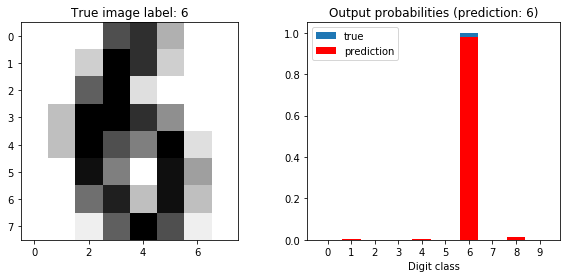

In [15]:
mlp_early_stopping.plot_validation_prediction(sample_id=41)

#### MLP with momentum

In [16]:
mlp_with_momentum = MultiLayerPerceptron(
    X, Y, hidden_size=50, 
    activation='relu', 
    dropout=False, 
    dropout_rate=0
)
mlp_with_momentum.train(
    optimizer='sgd',
    momentum=True,
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=True
)
print("**MLP with momentum**")
print("Training accuracy: {:.4f}".format(mlp_with_momentum.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_with_momentum.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_with_momentum.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_with_momentum.validation_losses_history[-1]))
print("Number of iterations: {:d}".format(len(mlp_with_momentum.training_losses_history)))

iteration number: 1	 training loss: 2.3025	validation loss: 2.3028	 validation accuracy: 0.0911
iteration number: 2	 training loss: 2.3024	validation loss: 2.3029	 validation accuracy: 0.0911
iteration number: 3	 training loss: 2.3023	validation loss: 2.3032	 validation accuracy: 0.0911
iteration number: 4	 training loss: 2.3022	validation loss: 2.3036	 validation accuracy: 0.0844
iteration number: 5	 training loss: 2.3021	validation loss: 2.3042	 validation accuracy: 0.0844
iteration number: 6	 training loss: 2.3020	validation loss: 2.3046	 validation accuracy: 0.0844
iteration number: 7	 training loss: 2.3020	validation loss: 2.3050	 validation accuracy: 0.0844
iteration number: 8	 training loss: 2.3019	validation loss: 2.3054	 validation accuracy: 0.0844
iteration number: 9	 training loss: 2.3020	validation loss: 2.3059	 validation accuracy: 0.0844
iteration number: 10	 training loss: 2.3020	validation loss: 2.3062	 validation accuracy: 0.0844
iteration number: 11	 training loss: 2.

iteration number: 150	 training loss: 0.1120	validation loss: 0.1690	 validation accuracy: 0.9489
iteration number: 151	 training loss: 0.1119	validation loss: 0.1667	 validation accuracy: 0.9489
iteration number: 152	 training loss: 0.1113	validation loss: 0.1663	 validation accuracy: 0.9489
iteration number: 153	 training loss: 0.1114	validation loss: 0.1661	 validation accuracy: 0.9489
iteration number: 154	 training loss: 0.1116	validation loss: 0.1697	 validation accuracy: 0.9467
iteration number: 155	 training loss: 0.1109	validation loss: 0.1772	 validation accuracy: 0.9422
iteration number: 156	 training loss: 0.1090	validation loss: 0.1851	 validation accuracy: 0.9467
iteration number: 157	 training loss: 0.1088	validation loss: 0.1957	 validation accuracy: 0.9400
iteration number: 158	 training loss: 0.1052	validation loss: 0.1947	 validation accuracy: 0.9444
iteration number: 159	 training loss: 0.1018	validation loss: 0.1880	 validation accuracy: 0.9378
iteration number: 16

iteration number: 285	 training loss: 0.0523	validation loss: 0.1397	 validation accuracy: 0.9489
iteration number: 286	 training loss: 0.0547	validation loss: 0.1446	 validation accuracy: 0.9467
iteration number: 287	 training loss: 0.0593	validation loss: 0.1534	 validation accuracy: 0.9467
iteration number: 288	 training loss: 0.0658	validation loss: 0.1634	 validation accuracy: 0.9400
iteration number: 289	 training loss: 0.0670	validation loss: 0.1654	 validation accuracy: 0.9422
iteration number: 290	 training loss: 0.0648	validation loss: 0.1629	 validation accuracy: 0.9489
iteration number: 291	 training loss: 0.0591	validation loss: 0.1547	 validation accuracy: 0.9467
iteration number: 292	 training loss: 0.0558	validation loss: 0.1494	 validation accuracy: 0.9533
iteration number: 293	 training loss: 0.0563	validation loss: 0.1500	 validation accuracy: 0.9533
iteration number: 294	 training loss: 0.0596	validation loss: 0.1575	 validation accuracy: 0.9511
iteration number: 29

iteration number: 425	 training loss: 0.0301	validation loss: 0.1329	 validation accuracy: 0.9489
iteration number: 426	 training loss: 0.0296	validation loss: 0.1294	 validation accuracy: 0.9533
iteration number: 427	 training loss: 0.0295	validation loss: 0.1267	 validation accuracy: 0.9511
iteration number: 428	 training loss: 0.0301	validation loss: 0.1249	 validation accuracy: 0.9556
iteration number: 429	 training loss: 0.0310	validation loss: 0.1248	 validation accuracy: 0.9556
iteration number: 430	 training loss: 0.0319	validation loss: 0.1261	 validation accuracy: 0.9533
iteration number: 431	 training loss: 0.0325	validation loss: 0.1303	 validation accuracy: 0.9533
iteration number: 432	 training loss: 0.0339	validation loss: 0.1360	 validation accuracy: 0.9533
iteration number: 433	 training loss: 0.0324	validation loss: 0.1382	 validation accuracy: 0.9533
iteration number: 434	 training loss: 0.0298	validation loss: 0.1409	 validation accuracy: 0.9556
iteration number: 43

iteration number: 571	 training loss: 0.0225	validation loss: 0.1157	 validation accuracy: 0.9578
iteration number: 572	 training loss: 0.0223	validation loss: 0.1164	 validation accuracy: 0.9578
iteration number: 573	 training loss: 0.0217	validation loss: 0.1177	 validation accuracy: 0.9578
iteration number: 574	 training loss: 0.0210	validation loss: 0.1188	 validation accuracy: 0.9600
iteration number: 575	 training loss: 0.0208	validation loss: 0.1221	 validation accuracy: 0.9533
iteration number: 576	 training loss: 0.0204	validation loss: 0.1246	 validation accuracy: 0.9533
iteration number: 577	 training loss: 0.0192	validation loss: 0.1262	 validation accuracy: 0.9600
iteration number: 578	 training loss: 0.0184	validation loss: 0.1282	 validation accuracy: 0.9578
iteration number: 579	 training loss: 0.0179	validation loss: 0.1310	 validation accuracy: 0.9556
iteration number: 580	 training loss: 0.0177	validation loss: 0.1338	 validation accuracy: 0.9556
iteration number: 58

iteration number: 714	 training loss: 0.0143	validation loss: 0.1569	 validation accuracy: 0.9489
iteration number: 715	 training loss: 0.0143	validation loss: 0.1557	 validation accuracy: 0.9444
iteration number: 716	 training loss: 0.0146	validation loss: 0.1544	 validation accuracy: 0.9422
iteration number: 717	 training loss: 0.0140	validation loss: 0.1510	 validation accuracy: 0.9444
iteration number: 718	 training loss: 0.0133	validation loss: 0.1469	 validation accuracy: 0.9489
iteration number: 719	 training loss: 0.0128	validation loss: 0.1428	 validation accuracy: 0.9489
iteration number: 720	 training loss: 0.0124	validation loss: 0.1381	 validation accuracy: 0.9489
iteration number: 721	 training loss: 0.0121	validation loss: 0.1329	 validation accuracy: 0.9511
iteration number: 722	 training loss: 0.0120	validation loss: 0.1282	 validation accuracy: 0.9533
iteration number: 723	 training loss: 0.0120	validation loss: 0.1238	 validation accuracy: 0.9556
iteration number: 72

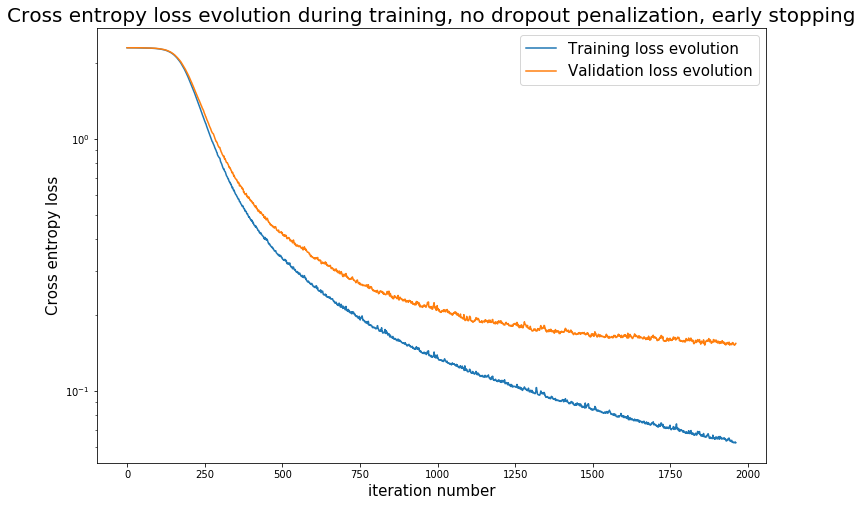

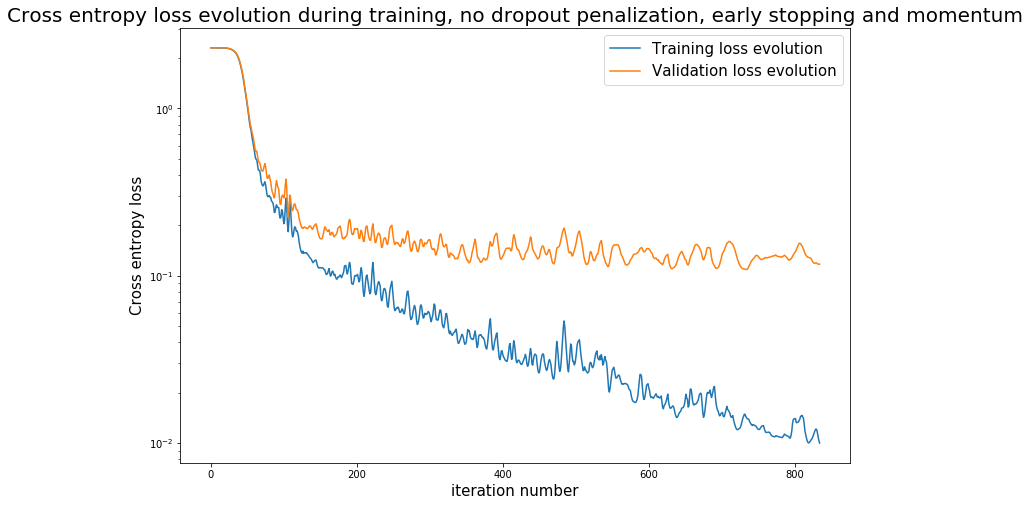

In [17]:
mlp_early_stopping.plot_loss_history(add_to_title="early stopping")
mlp_with_momentum.plot_loss_history(add_to_title="early stopping and momentum")

#### Comparing without and with dropout

In [18]:
mlp_without_dropout = MultiLayerPerceptron(
    X, Y, hidden_size=50, 
    activation='relu', 
    dropout=False
)
mlp_without_dropout.train(
    optimizer='sgd',
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=False
)
print("**MLP without early stopping nor dropout**")
print("Training accuracy: {:.4f}".format(mlp_without_dropout.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_without_dropout.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_without_dropout.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_without_dropout.validation_losses_history[-1]))

**MLP without early stopping nor dropout**
Training accuracy: 0.9785
Validation accuracy: 0.9511
Training loss: 0.0915
Validation loss: 0.1491


In [19]:
mlp_with_dropout = MultiLayerPerceptron(
    X, Y, hidden_size=50,
    activation='relu',
    dropout=True,
    dropout_rate=0.25
)
mlp_with_dropout.train(
    optimizer='sgd',
    min_iterations=500,
    max_iterations=5000,
    initial_step=1e-1,
    batch_size=64,
    early_stopping=True,
    early_stopping_lookbehind=100,
    early_stopping_delta=1e-4, 
    vectorized=True,
    verbose=False
)
print("**MLP with dropout**")
print("Training accuracy: {:.4f}".format(mlp_with_dropout.accuracy_on_train()))
print("Validation accuracy: {:.4f}".format(mlp_with_dropout.accuracy_on_validation()))
print("Training loss: {:.4f}".format(mlp_with_dropout.training_losses_history[-1]))
print("Validation loss: {:.4f}".format(mlp_with_dropout.validation_losses_history[-1]))

**MLP with dropout**
Training accuracy: 0.9681
Validation accuracy: 0.9556
Training loss: 0.1078
Validation loss: 0.1353


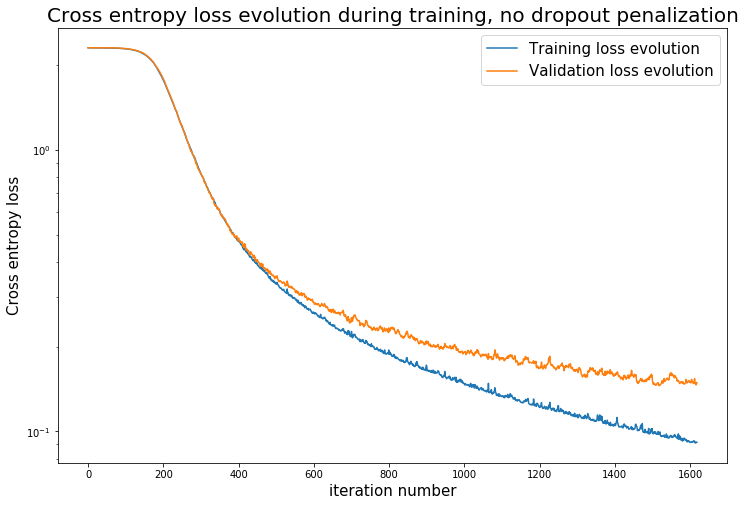

In [20]:
mlp_without_dropout.plot_loss_history()

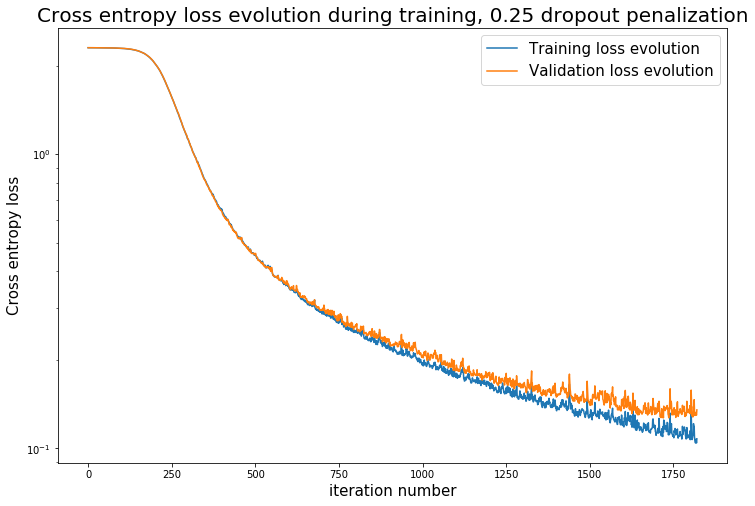

In [21]:
mlp_with_dropout.plot_loss_history()

# III - Multiclass classification MLP with Keras

#### - Implement the same network architecture with Keras;
    - First using the Sequential API
    - Secondly using the functional API

#### - Check that the Keras model can approximately reproduce the behavior of the Numpy model.

#### - Compute the negative log likelihood of a sample 42 in the validation set (can use `model.predict_proba`).

#### - Compute the average negative log-likelihood on the full validation set.

#### - Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

#### - Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 500 or more if necessary).

In [22]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

In [23]:
n_features = X[0].shape[0]
n_classes = len(np.unique(Y_tr))
n_hidden = 10

### Sequential

In [24]:
#from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))
keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim=n_features, activation=activation))
keras_model.add(Dense(n_classes, activation='softmax'))
keras_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
keras_model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes),
    epochs=100, batch_size=32, verbose=1,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/100
1347/1347 [==============================] - 1s 487us/sample - loss: 2.2349 - accuracy: 0.1440 - val_loss: 2.1766 - val_accuracy: 0.2089
Epoch 2/100
1347/1347 [==============================] - 0s 58us/sample - loss: 2.1276 - accuracy: 0.2546 - val_loss: 2.0694 - val_accuracy: 0.3444
Epoch 3/100
1347/1347 [==============================] - 0s 45us/sample - loss: 2.0016 - accuracy: 0.3534 - val_loss: 1.9285 - val_accuracy: 0.3867
Epoch 4/100
1347/1347 [==============================] - 0s 42us/sample - loss: 1.8556 - accuracy: 0.4662 - val_loss: 1.7849 - val_accuracy: 0.4911
Epoch 5/100
1347/1347 [==============================] - 0s 46us/sample - loss: 1.7109 - accuracy: 0.5316 - val_loss: 1.6395 - val_accuracy: 0.5689
Epoch 6/100
1347/1347 [==============================] - 0s 47us/sample - loss: 1.5459 - accuracy: 0.6244 - val_loss: 1.4737 - val_accuracy: 0.6311
Epoch 7/100
1347/1347 [==============

1347/1347 [==============================] - 0s 42us/sample - loss: 0.1538 - accuracy: 0.9621 - val_loss: 0.1819 - val_accuracy: 0.9622
Epoch 56/100
1347/1347 [==============================] - 0s 44us/sample - loss: 0.1503 - accuracy: 0.9651 - val_loss: 0.1796 - val_accuracy: 0.9600
Epoch 57/100
1347/1347 [==============================] - 0s 43us/sample - loss: 0.1482 - accuracy: 0.9659 - val_loss: 0.1773 - val_accuracy: 0.9600
Epoch 58/100
1347/1347 [==============================] - 0s 44us/sample - loss: 0.1459 - accuracy: 0.9659 - val_loss: 0.1759 - val_accuracy: 0.9578
Epoch 59/100
1347/1347 [==============================] - 0s 43us/sample - loss: 0.1418 - accuracy: 0.9651 - val_loss: 0.1741 - val_accuracy: 0.9622
Epoch 60/100
1347/1347 [==============================] - 0s 42us/sample - loss: 0.1392 - accuracy: 0.9681 - val_loss: 0.1730 - val_accuracy: 0.9622
Epoch 61/100
1347/1347 [==============================] - 0s 46us/sample - loss: 0.1366 - accuracy: 0.9681 - val_loss: 

In [25]:
index_sample = 42

Y_val_one_hot_sample = to_categorical(Y_val[index_sample], num_classes=n_classes)
Y_val_pred_sample = np.squeeze(keras_model.predict_proba(np.expand_dims(X_val[index_sample], axis=0)))
nll_val_sample = -np.log(Y_val_one_hot_sample.dot(Y_val_pred_sample))
print("**Sample {:d}**".format(index_sample))
print("Negative loglikelihood: {:.7f}".format(nll_val_sample))

**Sample 42**
Negative loglikelihood: 0.0002235


In [26]:
Y_val_one_hot = to_categorical(Y_val, num_classes=n_classes)
Y_val_pred = keras_model.predict_proba(X_val)
nll_val = np.matmul(Y_val_one_hot.reshape(-1, 1, n_classes), Y_val_pred.reshape(-1, n_classes, 1))
nll_val = -np.mean(np.log(np.squeeze(nll_val)))
print("**Whole validation set**")
print("Negative loglikelihood: {:.7f}".format(nll_val))

**Whole validation set**
Negative loglikelihood: 0.1452658


In [27]:
Y_tr_one_hot = to_categorical(Y_tr, num_classes=n_classes)
Y_tr_pred = keras_model.predict_proba(X_tr)
nll_tr = np.matmul(Y_tr_one_hot.reshape(-1, 1, n_classes), Y_tr_pred.reshape(-1, n_classes, 1))
nll_tr = -np.mean(np.log(np.squeeze(nll_tr)))
print("**Whole training set**")
print("Our negative loglikelihood: {:.7f}".format(nll_tr))
keras_nll_tr = categorical_crossentropy(Y_tr_one_hot, Y_tr_pred)
keras_nll_tr = keras_nll_tr.numpy().mean()
print("Keras negative loglikelihood: {:.7f}".format(keras_nll_tr))

**Whole training set**
Our negative loglikelihood: 0.0707758
Keras negative loglikelihood: 0.0707758


### Functional

In [28]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
h_layer = Dense(n_hidden, activation=activation)(inputs)
y_layer = Dense(n_classes, activation='softmax')(h_layer)

model = Model(inputs=inputs, outputs=y_layer)
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes), 
    epochs=300, verbose=1, batch_size=32,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/300
1347/1347 [==============================] - 0s 360us/sample - loss: 2.2873 - accuracy: 0.0883 - val_loss: 2.2012 - val_accuracy: 0.1667
Epoch 2/300
1347/1347 [==============================] - 0s 56us/sample - loss: 2.1358 - accuracy: 0.2146 - val_loss: 2.0691 - val_accuracy: 0.2556
Epoch 3/300
1347/1347 [==============================] - 0s 46us/sample - loss: 2.0023 - accuracy: 0.3051 - val_loss: 1.9350 - val_accuracy: 0.3467
Epoch 4/300
1347/1347 [==============================] - 0s 46us/sample - loss: 1.8665 - accuracy: 0.3764 - val_loss: 1.7939 - val_accuracy: 0.4022
Epoch 5/300
1347/1347 [==============================] - 0s 47us/sample - loss: 1.7230 - accuracy: 0.4633 - val_loss: 1.6487 - val_accuracy: 0.4689
Epoch 6/300
1347/1347 [==============================] - 0s 47us/sample - loss: 1.5739 - accuracy: 0.5620 - val_loss: 1.5003 - val_accuracy: 0.5600
Epoch 7/300
1347/1347 [==============

1347/1347 [==============================] - 0s 47us/sample - loss: 0.1488 - accuracy: 0.9659 - val_loss: 0.1835 - val_accuracy: 0.9578
Epoch 56/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.1448 - accuracy: 0.9696 - val_loss: 0.1810 - val_accuracy: 0.9533
Epoch 57/300
1347/1347 [==============================] - 0s 48us/sample - loss: 0.1402 - accuracy: 0.9718 - val_loss: 0.1766 - val_accuracy: 0.9600
Epoch 58/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.1393 - accuracy: 0.9696 - val_loss: 0.1747 - val_accuracy: 0.9578
Epoch 59/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.1357 - accuracy: 0.9725 - val_loss: 0.1748 - val_accuracy: 0.9556
Epoch 60/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1337 - accuracy: 0.9733 - val_loss: 0.1721 - val_accuracy: 0.9600
Epoch 61/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1308 - accuracy: 0.9748 - val_loss: 

1347/1347 [==============================] - 0s 44us/sample - loss: 0.0621 - accuracy: 0.9881 - val_loss: 0.1360 - val_accuracy: 0.9622
Epoch 111/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0614 - accuracy: 0.9889 - val_loss: 0.1360 - val_accuracy: 0.9622
Epoch 112/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.0609 - accuracy: 0.9911 - val_loss: 0.1360 - val_accuracy: 0.9600
Epoch 113/300
1347/1347 [==============================] - 0s 49us/sample - loss: 0.0598 - accuracy: 0.9918 - val_loss: 0.1350 - val_accuracy: 0.9578
Epoch 114/300
1347/1347 [==============================] - 0s 49us/sample - loss: 0.0591 - accuracy: 0.9896 - val_loss: 0.1339 - val_accuracy: 0.9622
Epoch 115/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.0581 - accuracy: 0.9918 - val_loss: 0.1333 - val_accuracy: 0.9667
Epoch 116/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.0578 - accuracy: 0.9911 - val_

Epoch 165/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.0330 - accuracy: 0.9963 - val_loss: 0.1333 - val_accuracy: 0.9689
Epoch 166/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0328 - accuracy: 0.9963 - val_loss: 0.1337 - val_accuracy: 0.9689
Epoch 167/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0323 - accuracy: 0.9978 - val_loss: 0.1323 - val_accuracy: 0.9689
Epoch 168/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.0317 - accuracy: 0.9970 - val_loss: 0.1344 - val_accuracy: 0.9689
Epoch 169/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.0310 - accuracy: 0.9970 - val_loss: 0.1349 - val_accuracy: 0.9689
Epoch 170/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.0331 - accuracy: 0.9955 - val_loss: 0.1365 - val_accuracy: 0.9689
Epoch 171/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.0310 - accuracy:

1347/1347 [==============================] - 0s 48us/sample - loss: 0.0186 - accuracy: 0.9985 - val_loss: 0.1383 - val_accuracy: 0.9711
Epoch 220/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.0185 - accuracy: 0.9985 - val_loss: 0.1370 - val_accuracy: 0.9711
Epoch 221/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.0186 - accuracy: 0.9985 - val_loss: 0.1351 - val_accuracy: 0.9711
Epoch 222/300
1347/1347 [==============================] - 0s 48us/sample - loss: 0.0181 - accuracy: 0.9985 - val_loss: 0.1386 - val_accuracy: 0.9689
Epoch 223/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.0180 - accuracy: 0.9985 - val_loss: 0.1400 - val_accuracy: 0.9667
Epoch 224/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.0179 - accuracy: 0.9978 - val_loss: 0.1405 - val_accuracy: 0.9689
Epoch 225/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.0176 - accuracy: 0.9985 - val_

Epoch 274/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.0110 - accuracy: 0.9993 - val_loss: 0.1472 - val_accuracy: 0.9644
Epoch 275/300
1347/1347 [==============================] - 0s 41us/sample - loss: 0.0108 - accuracy: 0.9993 - val_loss: 0.1481 - val_accuracy: 0.9644
Epoch 276/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0106 - accuracy: 0.9985 - val_loss: 0.1468 - val_accuracy: 0.9644
Epoch 277/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.0105 - accuracy: 0.9993 - val_loss: 0.1483 - val_accuracy: 0.9622
Epoch 278/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.0105 - accuracy: 0.9993 - val_loss: 0.1467 - val_accuracy: 0.9711
Epoch 279/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.0133 - accuracy: 0.9985 - val_loss: 0.1510 - val_accuracy: 0.9622
Epoch 280/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.0119 - accuracy:

#### Now that you know if the model is underfitting or overfitting:
<span style="color:green">
Underfitting case: model not complex enough (not enough parameters and depth) to learn dependencies between $X$ and $Y$<br/>
Overfitting case: model too complex, learns statistically pointless dependencies between $X_{tr}$ and $Y_{tr}$
</span>

#### - In case of underfitting, can you explain why ? Also change the structure of the 2 previous networks to cancell underfitting
#### - In case of overfitting, explain why and change the structure of the 2 previous networks to cancell the overfitting
<span style="color:green">
We can observe a slight case of overfitting here, with a gap of about 5% between the training and the validation accuracies.<br/>Adding a Dropout with a small $p$ rate can be thus considered.
</span>

### Sequential without overfitting

In [29]:
from tensorflow.keras.layers import Dropout

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))
keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim=n_features, activation=activation))
keras_model.add(Dropout(0.1))
keras_model.add(Dense(n_classes, activation='softmax'))
keras_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
keras_model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes),
    epochs=300, batch_size=32, verbose=1,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/300
1347/1347 [==============================] - 1s 397us/sample - loss: 2.4092 - accuracy: 0.1062 - val_loss: 2.3101 - val_accuracy: 0.1311
Epoch 2/300
1347/1347 [==============================] - 0s 47us/sample - loss: 2.2243 - accuracy: 0.2042 - val_loss: 2.1640 - val_accuracy: 0.2844
Epoch 3/300
1347/1347 [==============================] - 0s 48us/sample - loss: 2.0774 - accuracy: 0.3385 - val_loss: 2.0213 - val_accuracy: 0.4244
Epoch 4/300
1347/1347 [==============================] - 0s 49us/sample - loss: 1.9483 - accuracy: 0.4143 - val_loss: 1.8795 - val_accuracy: 0.4933
Epoch 5/300
1347/1347 [==============================] - 0s 46us/sample - loss: 1.7945 - accuracy: 0.4714 - val_loss: 1.7110 - val_accuracy: 0.5244
Epoch 6/300
1347/1347 [==============================] - 0s 48us/sample - loss: 1.6434 - accuracy: 0.5286 - val_loss: 1.5586 - val_accuracy: 0.6356
Epoch 7/300
1347/1347 [==============

1347/1347 [==============================] - 0s 47us/sample - loss: 0.4366 - accuracy: 0.8582 - val_loss: 0.2780 - val_accuracy: 0.9333
Epoch 56/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.4180 - accuracy: 0.8656 - val_loss: 0.2782 - val_accuracy: 0.9311
Epoch 57/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.4139 - accuracy: 0.8597 - val_loss: 0.2729 - val_accuracy: 0.9356
Epoch 58/300
1347/1347 [==============================] - 0s 48us/sample - loss: 0.4176 - accuracy: 0.8656 - val_loss: 0.2699 - val_accuracy: 0.9378
Epoch 59/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.3979 - accuracy: 0.8797 - val_loss: 0.2679 - val_accuracy: 0.9356
Epoch 60/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.4201 - accuracy: 0.8612 - val_loss: 0.2657 - val_accuracy: 0.9378
Epoch 61/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.4265 - accuracy: 0.8619 - val_loss: 

1347/1347 [==============================] - 0s 48us/sample - loss: 0.3028 - accuracy: 0.8909 - val_loss: 0.1986 - val_accuracy: 0.9467
Epoch 111/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.2900 - accuracy: 0.9035 - val_loss: 0.1995 - val_accuracy: 0.9444
Epoch 112/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.2908 - accuracy: 0.9020 - val_loss: 0.1983 - val_accuracy: 0.9422
Epoch 113/300
1347/1347 [==============================] - 0s 48us/sample - loss: 0.2953 - accuracy: 0.8998 - val_loss: 0.1970 - val_accuracy: 0.9444
Epoch 114/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.2859 - accuracy: 0.9065 - val_loss: 0.1967 - val_accuracy: 0.9444
Epoch 115/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.2930 - accuracy: 0.9013 - val_loss: 0.1981 - val_accuracy: 0.9511
Epoch 116/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.2841 - accuracy: 0.8990 - val_

Epoch 165/300
1347/1347 [==============================] - 0s 48us/sample - loss: 0.2625 - accuracy: 0.9057 - val_loss: 0.1910 - val_accuracy: 0.9467
Epoch 166/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.2576 - accuracy: 0.9050 - val_loss: 0.1888 - val_accuracy: 0.9467
Epoch 167/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.2484 - accuracy: 0.9117 - val_loss: 0.1867 - val_accuracy: 0.9489
Epoch 168/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.2345 - accuracy: 0.9198 - val_loss: 0.1883 - val_accuracy: 0.9467
Epoch 169/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.2479 - accuracy: 0.9146 - val_loss: 0.1911 - val_accuracy: 0.9489
Epoch 170/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.2430 - accuracy: 0.9131 - val_loss: 0.1868 - val_accuracy: 0.9444
Epoch 171/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.2467 - accuracy:

1347/1347 [==============================] - 0s 41us/sample - loss: 0.2093 - accuracy: 0.9317 - val_loss: 0.1929 - val_accuracy: 0.9489
Epoch 220/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1969 - accuracy: 0.9324 - val_loss: 0.1978 - val_accuracy: 0.9400
Epoch 221/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.2050 - accuracy: 0.9272 - val_loss: 0.1950 - val_accuracy: 0.9467
Epoch 222/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.2163 - accuracy: 0.9287 - val_loss: 0.1962 - val_accuracy: 0.9400
Epoch 223/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.2355 - accuracy: 0.9109 - val_loss: 0.1921 - val_accuracy: 0.9467
Epoch 224/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.2276 - accuracy: 0.9206 - val_loss: 0.1945 - val_accuracy: 0.9467
Epoch 225/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.2499 - accuracy: 0.9169 - val_

Epoch 274/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.2017 - accuracy: 0.9369 - val_loss: 0.1943 - val_accuracy: 0.9467
Epoch 275/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1919 - accuracy: 0.9406 - val_loss: 0.1997 - val_accuracy: 0.9444
Epoch 276/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.2110 - accuracy: 0.9310 - val_loss: 0.1958 - val_accuracy: 0.9467
Epoch 277/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.2163 - accuracy: 0.9280 - val_loss: 0.1997 - val_accuracy: 0.9378
Epoch 278/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.2092 - accuracy: 0.9295 - val_loss: 0.1974 - val_accuracy: 0.9467
Epoch 279/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1927 - accuracy: 0.9362 - val_loss: 0.1979 - val_accuracy: 0.9422
Epoch 280/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.2073 - accuracy:

### Functional without overfitting

In [30]:
activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
h_layer = Dense(n_hidden, activation=activation)(inputs)
h_layer_dropout = Dropout(0.1)(h_layer)
y_layer = Dense(n_classes, activation='softmax')(h_layer_dropout)

model = Model(inputs=inputs, outputs=y_layer)
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    X_tr, to_categorical(Y_tr, num_classes=n_classes), 
    epochs=300, verbose=1, batch_size=32,
    validation_data=(X_val, to_categorical(Y_val, num_classes=n_classes))
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/300
1347/1347 [==============================] - 0s 313us/sample - loss: 2.4111 - accuracy: 0.1143 - val_loss: 2.2598 - val_accuracy: 0.1444
Epoch 2/300
1347/1347 [==============================] - 0s 53us/sample - loss: 2.2041 - accuracy: 0.1811 - val_loss: 2.1270 - val_accuracy: 0.2911
Epoch 3/300
1347/1347 [==============================] - 0s 50us/sample - loss: 2.0762 - accuracy: 0.3133 - val_loss: 2.0054 - val_accuracy: 0.3822
Epoch 4/300
1347/1347 [==============================] - 0s 50us/sample - loss: 1.9528 - accuracy: 0.3898 - val_loss: 1.8733 - val_accuracy: 0.4356
Epoch 5/300
1347/1347 [==============================] - 0s 45us/sample - loss: 1.8270 - accuracy: 0.4321 - val_loss: 1.7341 - val_accuracy: 0.5022
Epoch 6/300
1347/1347 [==============================] - 0s 49us/sample - loss: 1.6912 - accuracy: 0.4892 - val_loss: 1.5871 - val_accuracy: 0.5867
Epoch 7/300
1347/1347 [==============

1347/1347 [==============================] - 0s 47us/sample - loss: 0.3185 - accuracy: 0.8931 - val_loss: 0.2049 - val_accuracy: 0.9489
Epoch 56/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.2861 - accuracy: 0.9117 - val_loss: 0.2005 - val_accuracy: 0.9511
Epoch 57/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.3029 - accuracy: 0.9057 - val_loss: 0.1987 - val_accuracy: 0.9511
Epoch 58/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.3023 - accuracy: 0.9050 - val_loss: 0.1959 - val_accuracy: 0.9489
Epoch 59/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.2872 - accuracy: 0.9124 - val_loss: 0.1958 - val_accuracy: 0.9511
Epoch 60/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.3028 - accuracy: 0.9020 - val_loss: 0.1946 - val_accuracy: 0.9489
Epoch 61/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.3028 - accuracy: 0.9020 - val_loss: 

1347/1347 [==============================] - 0s 41us/sample - loss: 0.1910 - accuracy: 0.9421 - val_loss: 0.1522 - val_accuracy: 0.9600
Epoch 111/300
1347/1347 [==============================] - 0s 48us/sample - loss: 0.1926 - accuracy: 0.9391 - val_loss: 0.1528 - val_accuracy: 0.9556
Epoch 112/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.2040 - accuracy: 0.9347 - val_loss: 0.1532 - val_accuracy: 0.9533
Epoch 113/300
1347/1347 [==============================] - 0s 48us/sample - loss: 0.2094 - accuracy: 0.9362 - val_loss: 0.1536 - val_accuracy: 0.9533
Epoch 114/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.1998 - accuracy: 0.9347 - val_loss: 0.1513 - val_accuracy: 0.9556
Epoch 115/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.2002 - accuracy: 0.9391 - val_loss: 0.1513 - val_accuracy: 0.9578
Epoch 116/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.1918 - accuracy: 0.9347 - val_

Epoch 165/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.1540 - accuracy: 0.9517 - val_loss: 0.1494 - val_accuracy: 0.9556
Epoch 166/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.1572 - accuracy: 0.9532 - val_loss: 0.1503 - val_accuracy: 0.9578
Epoch 167/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.1680 - accuracy: 0.9495 - val_loss: 0.1504 - val_accuracy: 0.9578
Epoch 168/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1448 - accuracy: 0.9525 - val_loss: 0.1506 - val_accuracy: 0.9578
Epoch 169/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.1509 - accuracy: 0.9577 - val_loss: 0.1510 - val_accuracy: 0.9600
Epoch 170/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.1576 - accuracy: 0.9540 - val_loss: 0.1516 - val_accuracy: 0.9556
Epoch 171/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.1592 - accuracy:

1347/1347 [==============================] - 0s 47us/sample - loss: 0.1329 - accuracy: 0.9614 - val_loss: 0.1575 - val_accuracy: 0.9556
Epoch 220/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.1365 - accuracy: 0.9540 - val_loss: 0.1542 - val_accuracy: 0.9556
Epoch 221/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.1495 - accuracy: 0.9517 - val_loss: 0.1536 - val_accuracy: 0.9600
Epoch 222/300
1347/1347 [==============================] - 0s 52us/sample - loss: 0.1353 - accuracy: 0.9525 - val_loss: 0.1536 - val_accuracy: 0.9600
Epoch 223/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.1183 - accuracy: 0.9607 - val_loss: 0.1548 - val_accuracy: 0.9556
Epoch 224/300
1347/1347 [==============================] - 0s 51us/sample - loss: 0.1518 - accuracy: 0.9525 - val_loss: 0.1576 - val_accuracy: 0.9622
Epoch 225/300
1347/1347 [==============================] - 0s 56us/sample - loss: 0.1252 - accuracy: 0.9599 - val_

Epoch 274/300
1347/1347 [==============================] - 0s 42us/sample - loss: 0.1226 - accuracy: 0.9577 - val_loss: 0.1620 - val_accuracy: 0.9578
Epoch 275/300
1347/1347 [==============================] - 0s 46us/sample - loss: 0.1337 - accuracy: 0.9503 - val_loss: 0.1667 - val_accuracy: 0.9578
Epoch 276/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1186 - accuracy: 0.9621 - val_loss: 0.1678 - val_accuracy: 0.9511
Epoch 277/300
1347/1347 [==============================] - 0s 47us/sample - loss: 0.1207 - accuracy: 0.9607 - val_loss: 0.1641 - val_accuracy: 0.9578
Epoch 278/300
1347/1347 [==============================] - 0s 43us/sample - loss: 0.1232 - accuracy: 0.9547 - val_loss: 0.1650 - val_accuracy: 0.9556
Epoch 279/300
1347/1347 [==============================] - 0s 44us/sample - loss: 0.1291 - accuracy: 0.9562 - val_loss: 0.1663 - val_accuracy: 0.9622
Epoch 280/300
1347/1347 [==============================] - 0s 45us/sample - loss: 0.1293 - accuracy: